# Определение стоимости автомобилей

**Цель работы:**<br>
Построить модель, которая предсказывает рыночную стоимость автомобиля на основе его характеристик, в рамках определенных требований к ее качеству и скорости.

**Планируемое использование результата работы:**<br>
Результаты работы будут использованы заказчиком в разработке приложения (например, телеграм бота). Критерии, которые важны заказчику:
- качество предсказания;
- время обучения модели;
- время предсказания модели.

**Входные данные:**<br>
Заказчик предоставил данные о технических характеристиках, комплектации и ценах автомобилей, ранее представленных на рынке. Данных много, обучение, возможно, будет длительным.

**Задачи работы:**
1. Подготовить данные для дальнейшей работы.
2. Разработать несколько моделей машинного обучения (МО) для предсказания объемов запасов в скважинах.
3. Оценить качество и скорость работы моделей. 
4. Выбрать лучшую модель.



**План работы:**
<a id='begin'></a>

1. Шаг 1. Подготовка данных.
    - [[Перейти к разделу]](#step11). [[Перейти к выводу]](#conclusion11). Загрузка и зучение данных. Изучить входные данные, оценить полноту и качество входных данных для достижения цели исследования. Определить задачи предобработки данных.
    - [[Перейти к разделу]](#step12). [[Перейти к выводу]](#conclusion12). Преобработка данных. Осуществить предобработку данных в части улучшения качества данных для дальнейшего анализа.
    - [[Перейти к разделу]](#step13). [[Перейти к выводу]](#conclusion13). Исследовательский анализ данных. Провести исследовательский анализ данных, оценить (уточнить) необходимость формирования дополнительных категорий, параметров и групп данных для достижения цели исследования, провести корреляционный анализ данных.
    - [[Перейти к разделу]](#step14). [[Перейти к выводу]](#conclusion14). Подготовка данных к обучению, в том числе объединение или разделение необходимых данных в единый или различные дата-сеты, формирование новых признаков, дополнительных категорий и групп данных.
2. Шаг 2. Разработка моделей МО.
    - [[Перейти к разделу]](#step21). [[Перейти к выводу]](#conclusion21). Определение условий разработки моделей МО. Определиться с критериями разработки моделей, метриками качества моделей, критериями сравнения моделей.
    - [[Перейти к разделу]](#step22). [[Перейти к выводу]](#conclusion22). Основной этап моделирования. Разработать модели машинного обучения. Получить результаты для анализа их качества и скорости.
3. Шаг 3. [[Перейти к разделу]](#step3). [[Перейти к выводу]](#conclusion3). Оценка качества и скорости работы моделей, выбор лучшей модели.
4. Шаг 4. [[Перейти к разделу]](#step4) Оценка качества модели на тестовой выборке.

**[[Итоговый вывод]](#conclusion)**

## Импорт библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import seaborn as sns
import phik
import lightgbm as lgb
import time
import missingno as msno
import warnings

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import TransformerMixin
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler,
    OrdinalEncoder
)

In [2]:
notebook_time_start = time.time()

## Объявление констант и установок

In [3]:
RANDOM_STATE = 50

In [4]:
pd.set_option('display.max_columns', None)

In [5]:
TEST_VALID_SIZE = 0.25

In [6]:
warnings.filterwarnings('ignore')

## Создание функций

In [7]:
def overview_plot(df):
    """
    Функция, выводящая красивый график (подписанный, с адекватным 
    количеством корзин и гридом) только для числовых столбцов дата-сетов
    в целях предварительного анализа
    
    :param df: Дата-сет для которого проводится анализ
    :return: None # Результат выводится на экран  
    
    """    
     
    num_col_names = df.select_dtypes(include='number').columns.tolist()
    
    for col in num_col_names:
        # Применим правило Квиксола: количество интервалов (bins)
        # близко к квадратному корню из числа наблюдений.
        bins = int(np.round(math.sqrt(len(df[col])), 0))
        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        df[col].plot(
            kind='hist',
            bins=bins,
            grid=True,
            legend=False,
            ax=axes[0]
        )
        legend = '[' + col + ']'
        axes[0].set_title(
            'Распределение исследуемого параметра.\nСтолбец ' + legend
        )
        axes[0].set_xlabel(
            'Единицы изменения\nисследуемого параметра'
        )
        axes[0].set_ylabel(
            'Частота повторений\nисследуемого параметра'
        )
        
        df[col].plot(kind='box', grid=True, legend=False, ax=axes[1])
        axes[1].set_title(
            'Диаграмма размаха\nисследуемого параметра.\nСтолбец ' + legend
        )
        axes[1].set_xlabel(
            'Наименование\nисследуемого столбца'
        )
        axes[1].set_ylabel(
            'Единицы изменения\nисследуемого параметра'
        )
        fig.tight_layout()
        plt.show()
    
    if len(num_col_names) == 0: print('В дата-сете нет числовых столбцов')

In [8]:
def overview(df):
    """
    Функция, выводящая несколько элементов предварительного анализа данных
    
    :param df: Дата-сет для которого проводится анализ
    :return: несколько строк для отображения в Jupiter
    
    """    
     
    df.info()
    overview_plot(df)
    return df.sample(5)

In [9]:
def check_duplicates(df, columns):
    """
    Функция, проверяющая столбцы на наличие неявных дубликатов
    
    :param df: Дата-сет для которого проводится анализ
    :param columns: Список анализируемых столбцов дата-сета df
    :return: None; результат выводится на экран
    
    """    
    
    num_col_names = (
        df[columns]
        .select_dtypes(include='number')
        .columns.tolist()
    )
    str_col_names = (
        df[columns]
        .select_dtypes(exclude='number')
        .columns.tolist()
    )
    for col in str_col_names:
        print(f'Проверяем столбец [{col}]')
        print(
            '---> Количество уникальных значений: {}'
            .format(df[col].nunique())
        )
        print(
            '---> Количество уникальных значений'
            'после приведения к нижнему регистру: {}'
            .format(df[col].str.lower().nunique())
        )
        print(
            '---> Уникальные значения:',
            df[col].sort_values().unique()
        )
        print('%%%')
    for col in num_col_names:
        print(f'Проверяем столбец [{col}]')
        print(
            '---> Количество уникальных значений: {}'
            .format(df[col].nunique())
        )
        print(
            '---> Общее количество записей: {}'
            .format(len(df[col]))
        )
        print('%%%')

In [10]:
def plot_pie(data, axes, legend):
    """
    Функция, выводящая круговую диаграмму в соответствующую figure
    
    :param data: pandas.Series
    :param axes: matplotlib.axes.Axes
    :param legend: str
    :return: None; результат выводится на экран
    
    """    
    
    data.value_counts().plot(
        kind = 'pie', 
        autopct = '%1.0f%%',
        ylabel = '',
        title = 'Соотношение исследуемого параметра.\nСтолбец ' + legend,
        ax = axes
    )

def analysis_cat_cols(df, columns):
    """
    Функция, выводящая результаты анализа категориальных признаков 
    
    :param df: pandas.DataFrame; Дата-сет для которого проводится анализ
    :param columns: list; Список анализируемых столбцов дата-сета df
    :return: None; результат выводится на экран
    
    """    
    
    col_for_pie = []
    col_for_barh = []
    pie_plot = lambda x: True if x < 5 else False
    for col in columns:
        if pie_plot(df[col].nunique()):
            col_for_pie.append(col)
        else:
            col_for_barh.append(col)
    lenght = len(col_for_pie)
    rows = int(-(-lenght//4))
    if lenght == 1:
        legend = '[' + col_for_pie[0] + ']'
        plot_pie(df[col_for_pie[0]], None, legend)  
    elif rows > 1:
        cols = 4 if ((lenght % 4 != 1) or (lenght % 3 == 1)) else 3    
        fig, axes = plt.subplots(rows, cols, figsize=(5*cols, 3*rows))
        for i in range(0, len(col_for_pie)):
            legend = '[' + col_for_pie[i] + ']'
            plot_pie(df[col_for_pie[i]], axes[i // cols, i % cols], legend)
        for k in range(i+1, cols*rows):
            fig.delaxes(axes[k // cols][k % cols])        
        fig.tight_layout()
    else:
        cols = lenght
        fig, axes = plt.subplots(1, cols, figsize=(5*cols, 3*rows))
        for i in range(0, len(col_for_pie)):
            legend = '[' + col_for_pie[i] + ']'
            plot_pie(df[col_for_pie[i]], axes[i % cols], legend)
        fig.tight_layout()
    plt.show()
    
    for i in range(0, len(col_for_barh)):
        legend = '[' + col_for_barh[i] + ']'
        df[col_for_barh[i]].value_counts(ascending=True).plot(
            kind = 'bar', 
            title = 'Соотношение исследуемого параметра.\nСтолбец ' + legend,
            ylabel = '',
        )   
        plt.xlabel('Количество элементов')
        plt.ylabel('Категория')
        plt.show() 

In [11]:
def my_describe(df, column, desc=['hist', 'QR', 'describe', 'box', 'eject'],
                hist_desc=['Распределение\nисследуемого параметра',
                           'Единицы изменения\nисследуемого параметра',
                           'Частоста повторений\nисследуемого параметра'],
                box_desc=['Диаграмма размаха\nисследуемого параметра',
                           'Наименование\nисследуемого столбца',
                           'Единицы изменения\nисследуемого параметра']):
    """
    Функция, выводящая основные показатели для анализа количественных
    признаков
    
    :param df: pandas.DataFrame; дата-сет для которого проводится анализ
    :param column: str; столбец, для которого проводится анализ
    :param desc: list; способы вывода результатов анализа
    :param hist_desc: list; подписи для гистограммы
    :param box_desc: list; подписи для диаграммы размаха
    :return: None; результат выводится на экран
    
    """        
    
    legend_my_desc = 'Столбец' + ' [' + column + ']'
    
    if 'hist' in desc:
        bins = int(np.round(math.sqrt(len(df[column])), 0))
        df[column].plot(kind='hist', bins=bins, grid=True, legend=True)
        plt.title(hist_desc[0])
        plt.xlabel(hist_desc[1])
        plt.ylabel(hist_desc[2])
        plt.legend([legend_my_desc])
        plt.show()
        
    quartiles = df[column].quantile([0.25, 0.75])
    iqr = quartiles[0.75] - quartiles[0.25]
    min_diagramm = max(quartiles[0.25] - 1.5*iqr, df[column].min())
    max_diagramm = min(quartiles[0.75] + 1.5*iqr, df[column].max())  
    
    if 'describe' in desc:
        print()
        print('Ключевые характеристики распределения:')
        print(df[column].describe().apply("{0:.2f}".format))

    if 'QR' in desc:
        print()
        print('Ключевые характеристики диграммы размаха:')
        print('IQR\t\t\t{0:.2f}'.format(iqr))
        print('Q1-1,5*IQR\t\t{0:.2f}'.format(quartiles[0.25] - 1.5*iqr))
        print('MIN диаграммы размаха\t{0:.2f}'.format(min_diagramm))
        print('Q3+1,5*IQR\t\t{0:.2f}'.format(quartiles[0.75] + 1.5*iqr))      
        print('MAX диаграммы размаха\t{0:.2f}'.format(max_diagramm))
        print()
        
    if 'box' in desc:
        df[column].plot(kind='box', grid=True, legend=False)
        plt.title(box_desc[0])
        plt.xlabel(box_desc[1])
        plt.ylabel(box_desc[2])
        plt.show()
    
    if 'eject' in desc:
        print('Ключевые характеристики выбросов:')
        print('Количество выбросов (вверх)\t{0:.0f}'
              .format(len(df[df[column] > max_diagramm])))
        print('Доля выбросов (вверх)\t\t{0:.2f}%'
              .format(len(df[df[column] > max_diagramm]) / len(df) * 100))
        print('Количество выбросов (вниз)\t{0:.0f}'
              .format(len(df[df[column] < min_diagramm])))
        print('Доля выбросов (вниз)\t\t{0:.2f}%'
              .format(len(df[df[column] < min_diagramm]) / len(df) * 100))

In [12]:
def is_norm(data):
    """
    Функция, позволяющая оценить нормальность распределения количественной 
    величины
    
    :param data: pandas.Series; распределение, для которого проводится анализ
    :return: None; результат выводится на экран
    
    """        
    
    res = stats.normaltest(data)
    stats.probplot(data, dist='norm', plot=plt)
    plt.show()
    # Коэффициент статистической значимости установим 0.05
    if res.pvalue > 0.05:
        return (
            'p-value = {}. Имеются основания говорить'
            'о нормальности распределения'
            .format(res.pvalue)
        )
    else:
        return (
            'p-value = {}. Имеются основания говорить'
            'о НЕнормальности распределения'
            .format(res.pvalue)
        )

In [13]:
def corr_matrix(df, cols, corr_type, target=None, interval_cols=None):
    """
    Функция, формирующая матрицу корреляции
    
    :param df: pandas.Series; распределение, для которого проводится анализ
    :param cols: list
    :param corr_type: str, 'phik' или 'spearman' или ''
    :param target: str
    :return: None; результат выводится на экран
    
    """        
    
    new_cols = list(cols)
    if corr_type == 'phik':
        new_cols.append(target)
        corr = df[new_cols].phik_matrix(interval_cols=interval_cols)
    else:
        corr = df[new_cols].corr(method=corr_type)
    plt.figure(figsize = (10, 5))
    sns.heatmap(corr, vmin=-1, vmax=1,
                cmap='coolwarm', annot=True, fmt='.2f')
    #plt.xticks(rotation=45)
    plt.yticks(rotation=45)
    plt.title('Матрица корреляции')
    plt.show()

In [14]:
# Деление дата-сета на выборки для обучения
def prepare_split(df, goal, num_col_names, cat_col_names, val=False):
    
    columns_for_model = num_col_names + cat_col_names
    
    X = df[columns_for_model]
    y = df[goal]
    
    if not val:
        # Разобьем данные на обучающую и тестовую выборки
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size=TEST_VALID_SIZE,
            random_state=RANDOM_STATE
        )
        return X_train, y_train, X_test, y_test
    else:
        train = (1 - TEST_VALID_SIZE*2)
        test = TEST_VALID_SIZE
        val = TEST_VALID_SIZE
        # Разобьем данные на обучающую, тестовую и валидационную выборки
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size=0.25,
            random_state=RANDOM_STATE
        )
        X_train, X_valid, y_train, y_valid = train_test_split(
            X_train, 
            y_train, 
            test_size=0.25,
            random_state=RANDOM_STATE
        )
        return X_train, y_train, X_valid, y_valid, X_test, y_test,

# Шаг 1. Подготовка данных

## Загрузка и изучение данных 

<a id='step11' />

[Вернуться к началу](#begin)

In [15]:
data = pd.read_csv('../../datasets/autos.csv', sep=",")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

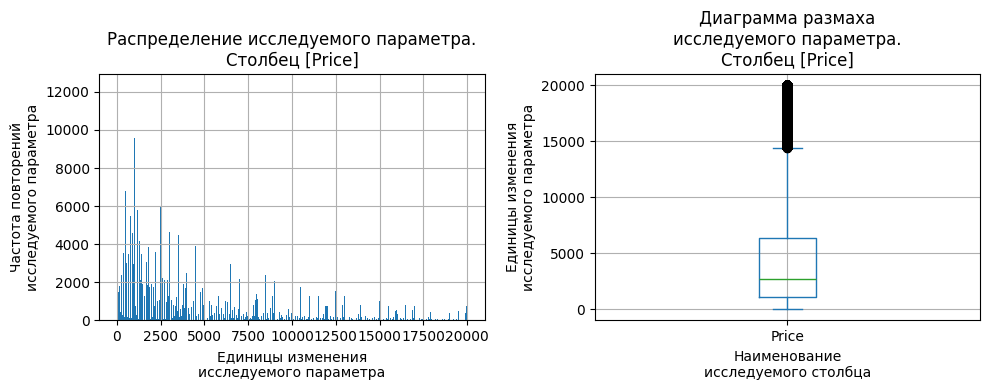

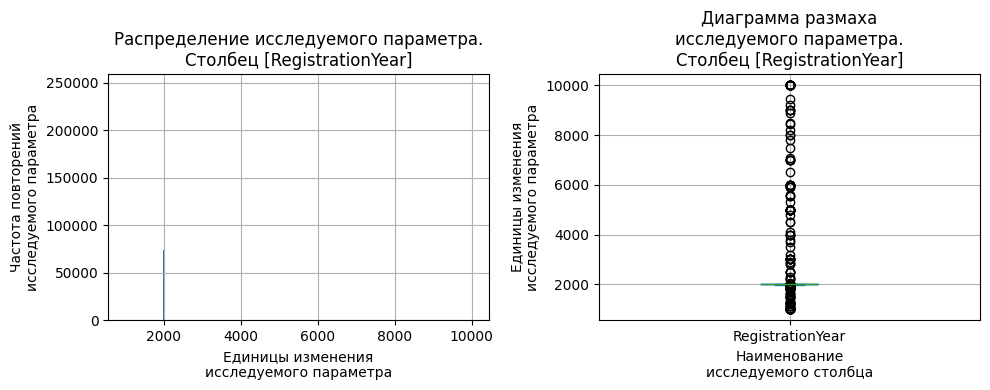

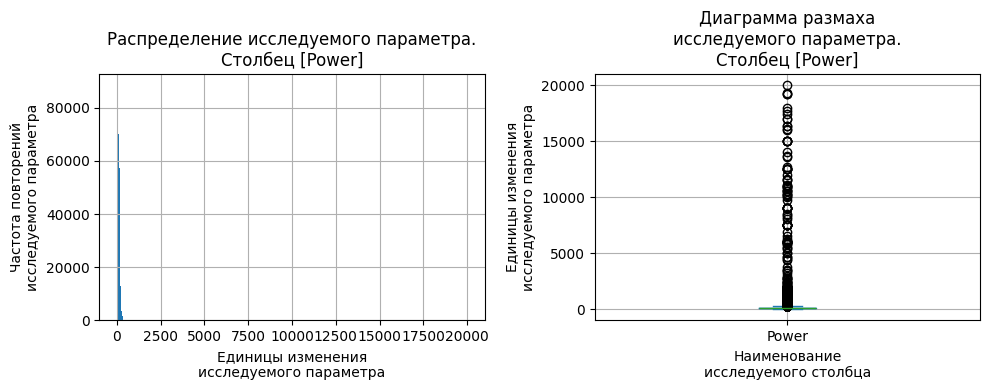

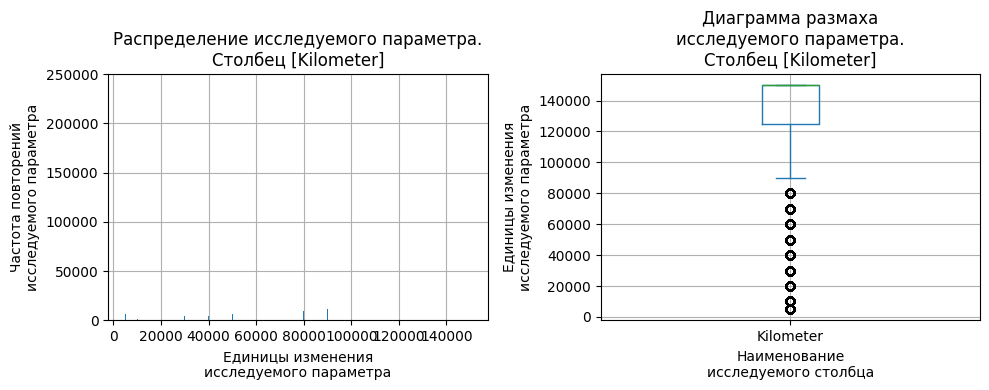

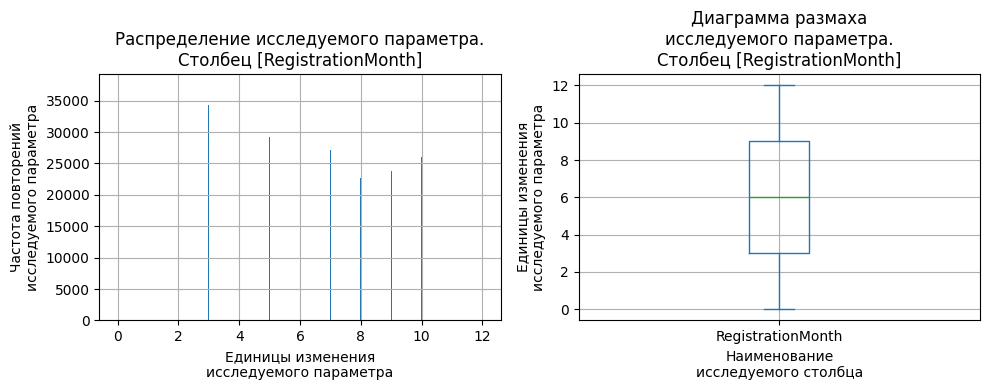

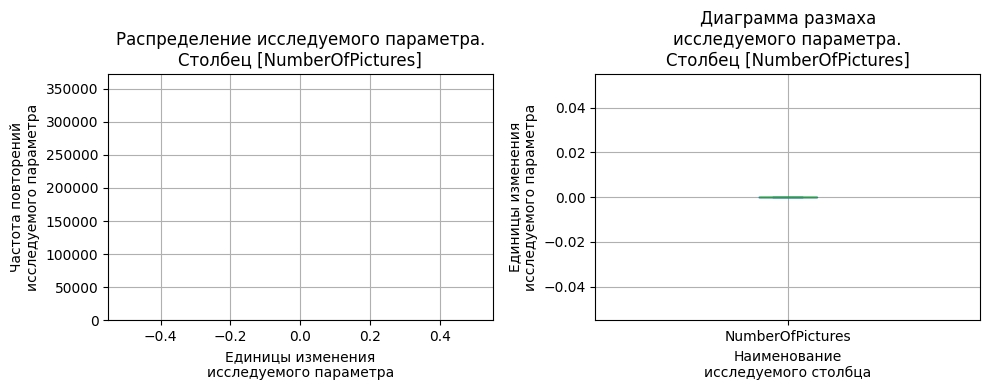

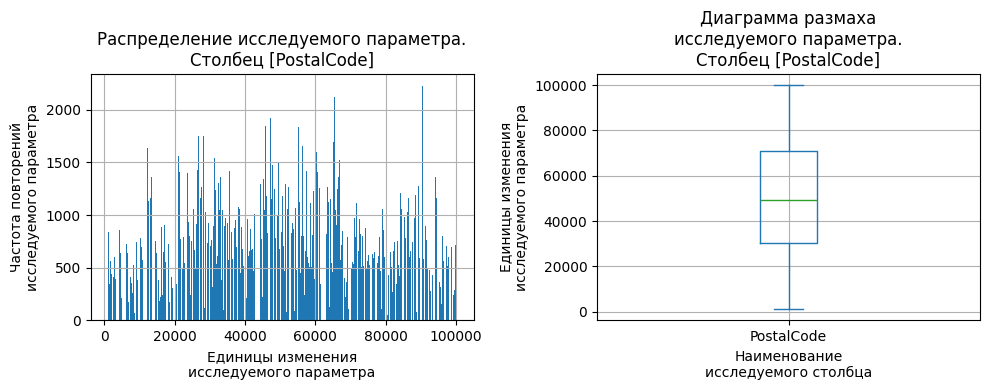

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
144721,2016-03-16 15:36:46,4790,sedan,2004,manual,75,golf,80000,5,petrol,volkswagen,no,2016-03-16 00:00:00,0,63637,2016-03-19 13:50:07
312624,2016-03-14 20:42:34,750,wagon,1998,manual,101,passat,150000,9,petrol,volkswagen,no,2016-03-14 00:00:00,0,24576,2016-03-14 20:42:34
260269,2016-04-04 22:37:12,6590,wagon,2004,manual,125,forester,125000,11,petrol,subaru,no,2016-04-04 00:00:00,0,93047,2016-04-07 02:17:04
98071,2016-03-16 12:56:57,2400,bus,2003,manual,0,sharan,150000,9,gasoline,volkswagen,NaN,2016-03-16 00:00:00,0,51065,2016-03-16 12:56:57
201303,2016-03-12 10:49:39,5990,small,2009,manual,69,fabia,20000,3,petrol,skoda,no,2016-03-12 00:00:00,0,84335,2016-03-29 17:16:57


In [16]:
# Изучим общую информацию о данных
overview(data)

На основании общих сведений о входных данных таблицы `data` сделаем выводы об их полноте и качестве для целей исследования:

1. Данные содержат 9 полей со строковым типом (object). При этом, в полях `DateCrawled`, `DateCreated`, `LastSeen` представлены даты в ISO формате. Для дальнейшей работы преобразуем тип указанных полей в datetime. Тип данных полей `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand` не вызывают сомнений. Поле `Repaired` представляется булевым типом, проверим на наличие неизвестных значений.
2. Данные содержат 7 полей с числовыми значениями. Типы полей не вызывают сомнений.
3. Гистограммы распределений полей с числовыми значениями показывают необходимость анализа выбросов и аномальных знчений. При этом, часть "выбросов" не представляются таковыми, например, цена 20000 евро вполне реалистична, в то же время год регистрации 10000 - сомнителен, возможно, необходимо оценить правильность использования единиц измерения. Аналогично для поля мощности атомобиля - мощность в 20000 единиц требует проверки в части используемых единиц измерения, отличных от л.с. Пробег автомобилей менее 80000 не должен являться выбросом.
4. Среди полей можно отметить несколько, влияние которых на стоимость автомобиля сомнительно. Яркий пример такого поля - PostalCode. Дата выгрузки объявления, дата его создания или последней активности пользователя тоже. Однако, представляется, что данные максимально за 2016 год. Проверим это. Возможно это окажет влияние на поле с годом регистрации автомобиля.
5. В полях `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Repaired` выявлены пропуски. Изучим их подробнее.
6. В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `Repaired` могут оказать неявные дубликаты. Необходим дополнительный анализ.

Визуализируем пропуски в данных.

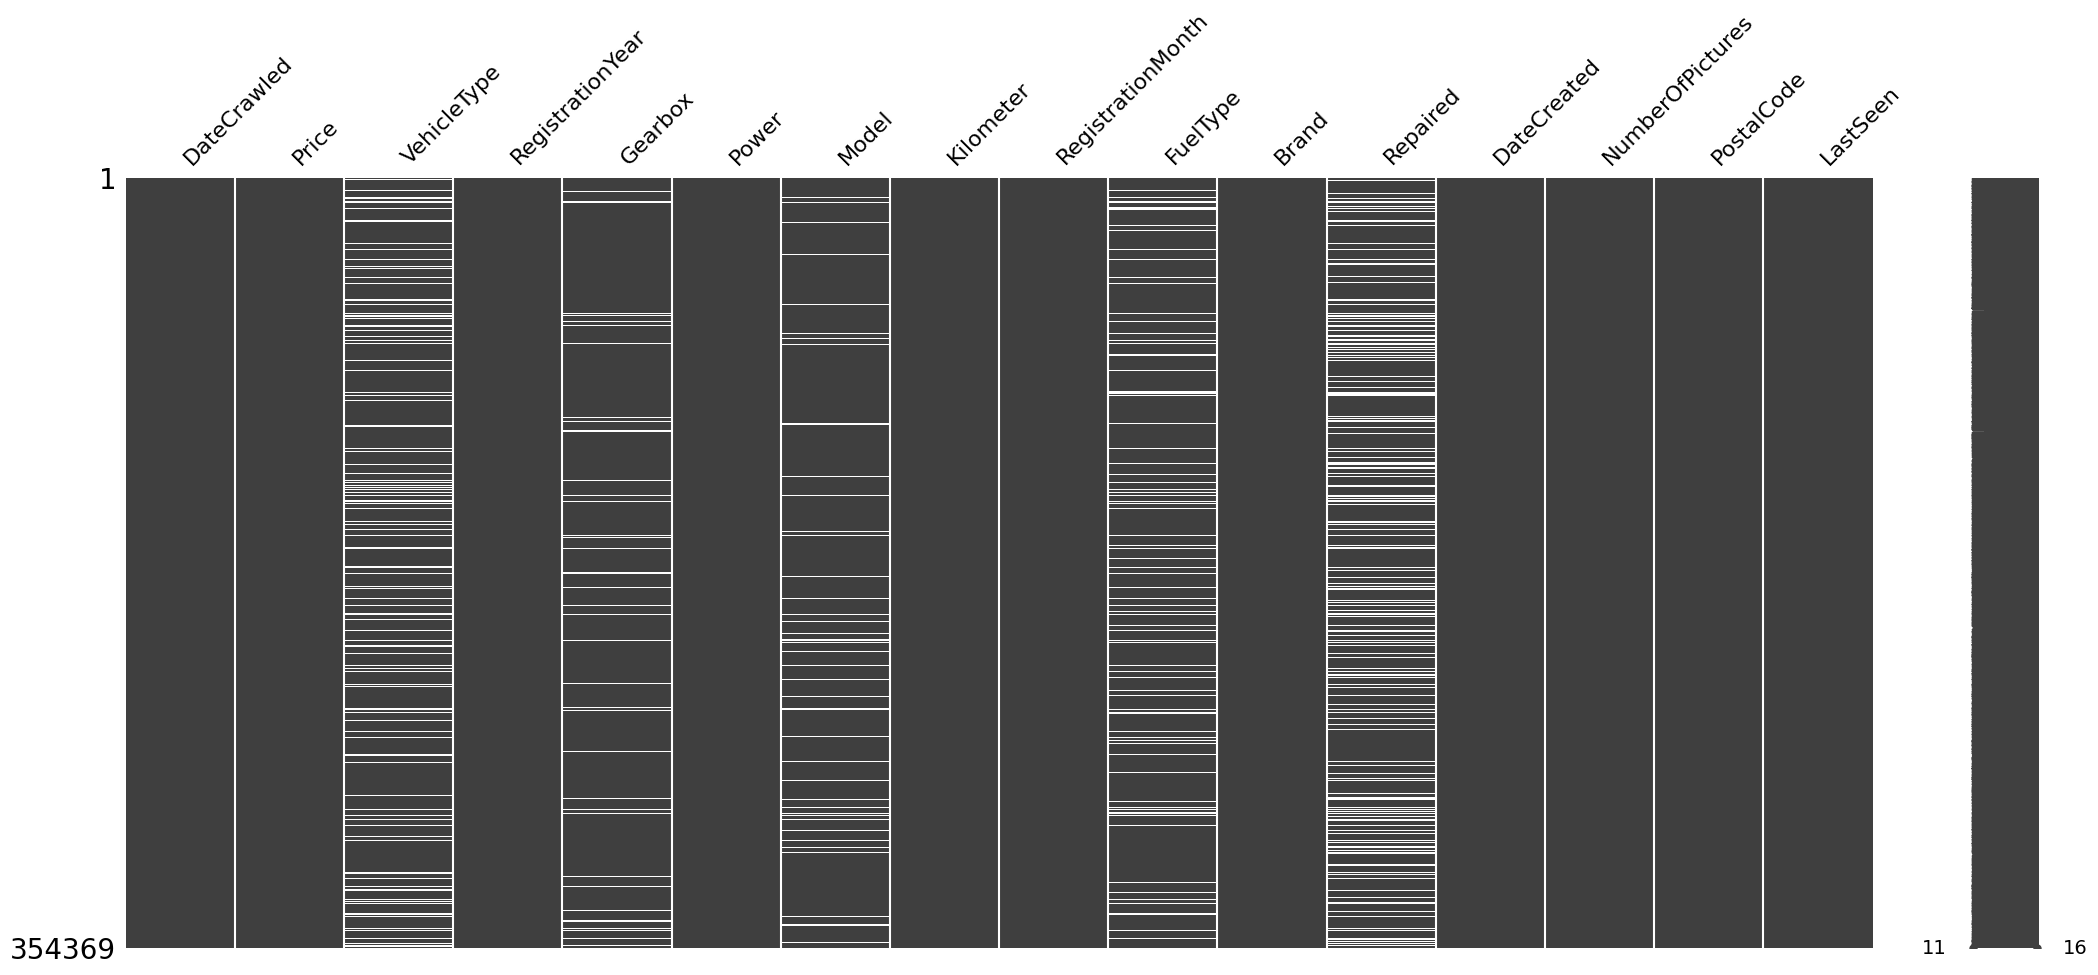

In [17]:
msno.matrix(data)
plt.show()

Визуально пропуски представлены в различных записях, корреляция слабая. Проверим это.

In [18]:
data[
    [
        'VehicleType', 
        'Gearbox', 
        'Model', 
        'FuelType', 
        'Repaired'
    ]
].isna().corr()

,VehicleType,Gearbox,Model,FuelType,Repaired
VehicleType,1.000000,0.314202,0.189908,0.436779,0.298733
Gearbox,0.314202,1.000000,0.162229,0.299483,0.269865
Model,0.189908,0.162229,1.000000,0.226342,0.156695
FuelType,0.436779,0.299483,0.226342,1.000000,0.242168
Repaired,0.298733,0.269865,0.156695,0.242168,1.000000


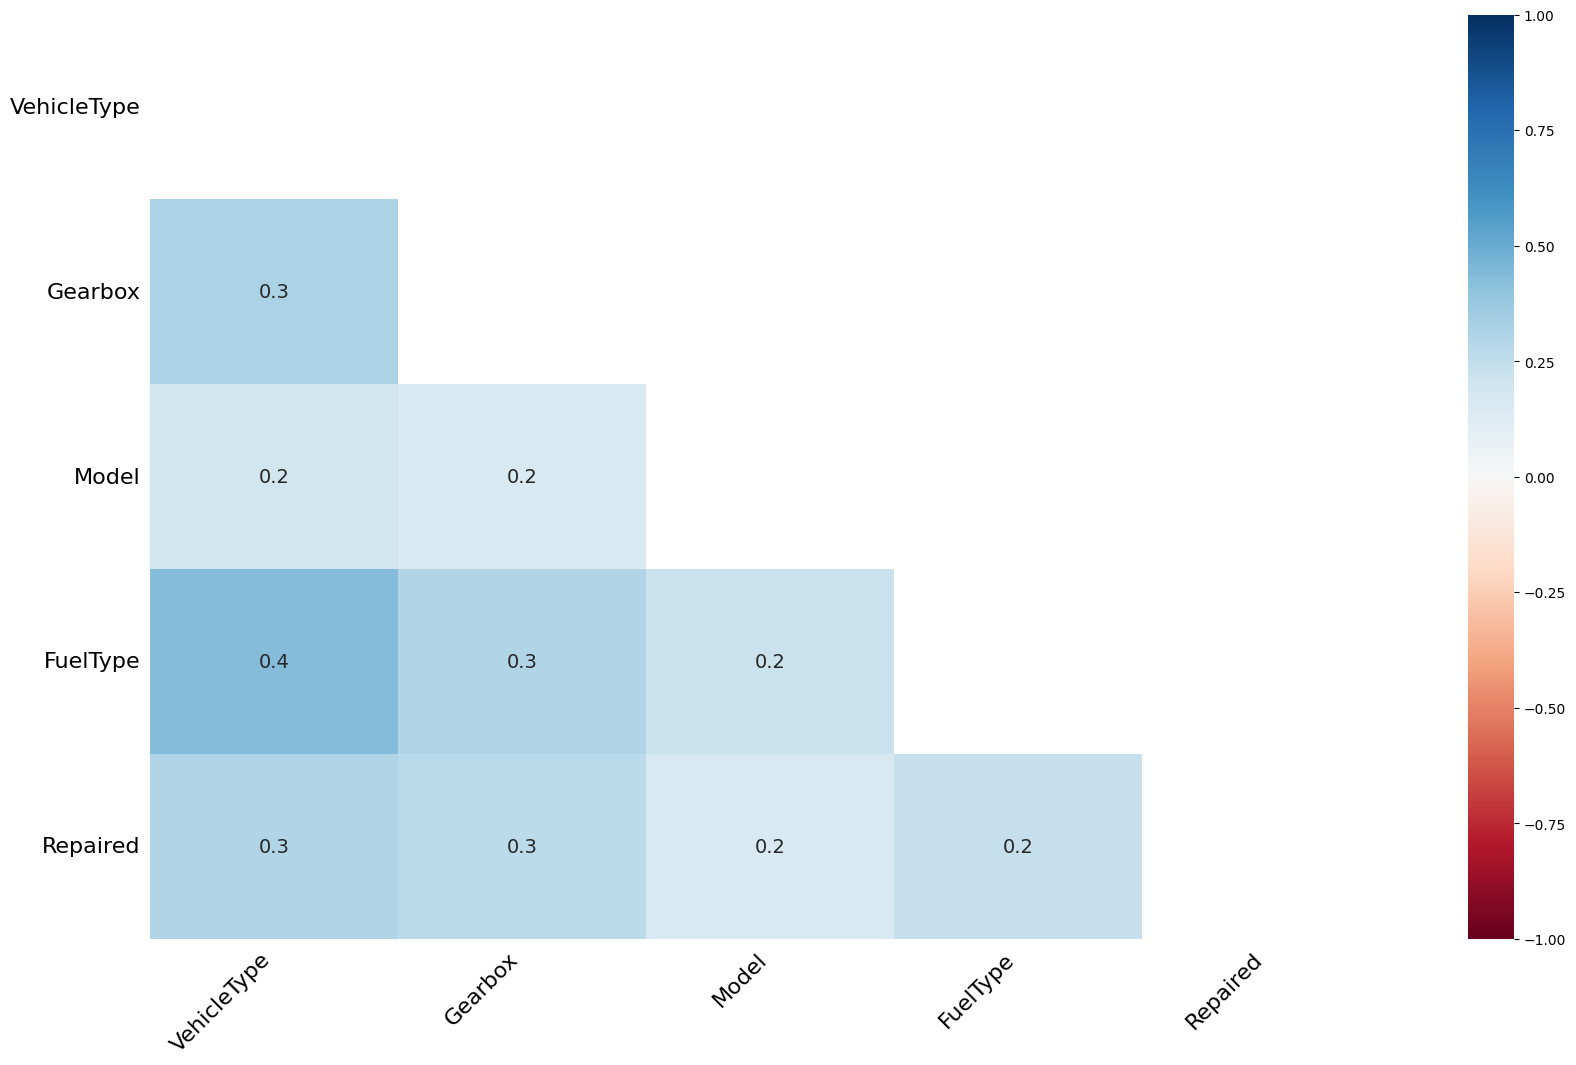

In [19]:
msno.heatmap(data)
plt.show()

Определим объем пропусков.

In [20]:
data.isna().sum()/len(data)*100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Kilometer             0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
Repaired             20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

Действительно, пропуски в данных имеют слабую корреляцию. С учетом характера данных и полей с пропущенными значениями можно сделать следующие выводы:
1. Значения полей `VehicleType`, `Gearbox`, `Model`, `FuelType` могут повторяться от автомобиля к автомобилю с другими одинаковыми характеристиками. Низкая корреляция пропусков может позволить заполнить часть пропусков для однотипных автомобилей. Не заполненные пропуски предлагается удалить.
2. Значения поля `Repaired` адекватно заполнить сложно и значения указанного поля могут сильно влиять на целевой признак. Пропусков много (около 20%), однако, их предлагается удалить.

### Вывод по разделу "Загрузка и изучение входных данных" <a id='conclusion11' />

[Вернуться к началу](#begin)

В ходе изучения входных данных были сделаны следующие выводы.

На основании общих сведений о входных данных таблицы `data` сделаем выводы об их полноте и качестве для целей исследования:

1. Данные содержат 9 полей со строковым типом (object). При этом, в полях `DateCrawled`, `DateCreated`, `LastSeen` представлены даты в ISO формате. Для дальнейшей работы преобразуем тип указанных полей в datetime. Тип данных полей `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand` не вызывают сомнений. Поле `Repaired` представляется булевым типом, проверим на наличие неизвестных значений.
2. Данные содержат 7 полей с числовыми значениями. Типы полей не вызывают сомнений.
3. Гистограммы распределений полей с числовыми значениями показывают необходимость анализа выбросов и аномальных знчений. При этом, часть "выбросов" не представляются таковыми, например, цена 20000 евро вполне реалистична, в то же время год регистрации 10000 - сомнителен, возможно, необходимо оценить правильность использования единиц измерения. Аналогично для поля мощности атомобиля - мощность в 20000 единиц требует проверки в части используемых единиц измерения, отличных от л.с. Пробег автомобилей менее 80000 не должен являться выбросом.
4. Среди полей можно отметить несколько, влияние которых на стоимость автомобиля сомнительно. Яркий пример такого поля - PostalCode. Среди полей можно отметить несколько, влияние которых на стоимость автомобиля сомнительно. Яркий пример такого поля - PostalCode. Дата выгрузки объявления, дата его создания или последней активности пользователя тоже. Однако, представляется, что данные максимально за 2016 год. Проверим это. Возможно это окажет влияние на поле с годом регистрации автомобиля. Кроме того, такие поля могут также влиять на наличие дубликатов в данных. Проверим это отдельно. 
5. В полях `VehicleType`, `Gearbox`, `Model`, `FuelType` выявлены пропуски. Значения полей могут повторяться от автомобиля к автомобилю с другими одинаковыми характеристиками. Низкая корреляция пропусков может позволить заполнить часть пропусков для однотипных автомобилей. Не заполненные пропуски предлагается удалить.
6. Выявлены пропуски в поле `Repaired`. Их адекватно заполнить сложно и значения указанного поля могут сильно влиять на целевой признак. Пропусков много (около 20%), однако, их предлагается удалить.
7. В столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType`, `Brand`, `Repaired` могут оказать неявные дубликаты. Необходим дополнительный анализ.

## Преобработка данных 

<a id='step12' />

[Вернуться к началу](#begin)

Прозведем предобработку данных на основании ранее сделанных выводов:

1. Изучим и обработаем пропуски в данных. Примем решение о работе с пропусками при обучении моделей.
2. Проверим наличие дубликатов и обработаем их при необходимости.
3. Обработаем типы данных.

Предварительно создадим копию входных данных для текущего этапа работы.

In [21]:
preprocessing_data = data.copy()

### Обработка пропусков

До обработки пропусков проверим размерность нашего дата-сета.

In [22]:
preprocessing_data.shape

(354369, 16)

**Пропуски в полях `VehicleType`, `Gearbox`, `Model`, `FuelType`**

Проверим общее количество записей, котоыре будут удалены в случае принятия решения об удалении всех пропусков.

In [23]:
del_data = preprocessing_data[
    (
        preprocessing_data['VehicleType'].isna()
        | preprocessing_data['Gearbox'].isna()
        | preprocessing_data['Model'].isna()
        | preprocessing_data['FuelType'].isna()
    )
]
del_data

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06
13,2016-03-21 21:37:40,2500,wagon,2004,manual,131,passat,150000,2,NaN,volkswagen,no,2016-03-21 00:00:00,0,90762,2016-03-23 02:50:54
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11 00:00:00,0,24148,2016-03-19 08:46:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354346,2016-03-07 17:06:35,2600,NaN,2005,auto,0,c_klasse,150000,9,NaN,mercedes_benz,NaN,2016-03-07 00:00:00,0,61169,2016-03-08 21:28:38
354351,2016-03-11 23:40:32,1900,NaN,2000,manual,110,NaN,150000,7,NaN,volkswagen,no,2016-03-11 00:00:00,0,87700,2016-03-12 14:16:51
354361,2016-03-09 13:37:43,5250,NaN,2016,auto,150,159,150000,12,NaN,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49


Удалению подлежат 70243 пропусков или 19.8% данных. Изучим поля с пропусками для понимания принципов их заполнения.

**Пропуски в поле `Model`**

In [24]:
preprocessing_data['Model'].isna().sum()

19705

Рассмотрм уникальные значения поля

In [25]:
preprocessing_data['Model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [26]:
preprocessing_data['Brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

В поле представлено значение 'other'. Представляется логичным заполнить пропуски именно этим значением. Однако, мы могли бы заполнить это поле наиболее часто встречающимся значением среди всех автомобилей одного бренда. При невозможности такого заполнения используем значение other.

**Пропуски в поле `VehicleType`**

In [27]:
preprocessing_data['VehicleType'].isna().sum()

37490

Рассмотрим уникальные значения поля

In [28]:
preprocessing_data['VehicleType'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

В поле представлено значение 'other'. Представляется логичным заполнить пропуски именно этим значением. В принципе, мы могли бы заполнить это поле на основании полей Model и Brand, предполагая, что одинаковые машины имеют одинаковый тип (при этом понимая, что, например, kia ceed может оказаться как хэтчбэк, так и универсал, но такие явления не часты, будем использовать наиболее частое значение). Реализуем указанный подход

**Пропуски в поле `Gearbox`**

In [29]:
preprocessing_data['Gearbox'].isna().sum()

19833

Рассмотрм уникальные значения поля

In [30]:
preprocessing_data['Gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

В поле представлены только два значения. Заполним пропуски в поле аналогично предыдущим полям на основании бренда и модели.

**Пропуски в поле `FuelType`**

In [31]:
preprocessing_data['FuelType'].isna().sum()

32895

Рассмотрм уникальные значения поля

In [32]:
preprocessing_data['FuelType'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

В поле представлены только два значения. Заполним пропуски в поле аналогично предыдущим полям на основании бренда и модели.

**Заполним пропуски на основе вышеуказанных принципов с использованием собственного импутера на базе TransformerMixin.**

In [33]:
class CustomImputer(TransformerMixin):
    def __init__(self, group_columns, fill_columns, unknown_value=None):
        self.group_columns = group_columns
        self.fill_columns = fill_columns
        self.unknown_value = unknown_value
        self.mode_values = None

    def fit(self, X):
        self.mode_values = (
            X.groupby(self.group_columns)[self.fill_columns]
            .apply(
                lambda x: x.mode(dropna=False).iloc[:1]
            )
            .fillna(self.unknown_value).reset_index()
        )
        return self

    def transform(self, X):
        X_copy = X.copy()
        #print(X_copy)
        merged_data = pd.merge(
            X_copy, 
            self.mode_values, 
            on=self.group_columns, 
            how='left', 
            suffixes=('', '_mode')
        )
        for fill_column in self.fill_columns:
            X_copy[fill_column] = (
                X_copy[fill_column]
                .combine_first(merged_data[fill_column + '_mode'])
            )
        
        return X_copy

Заполним поле `Model`

In [34]:
imputer_model = CustomImputer(group_columns=['Brand'], fill_columns=['Model'], unknown_value='other')
preprocessing_data = imputer_model.fit_transform(preprocessing_data)

Заполним поля 'VehicleType', 'Gearbox', 'FuelType'.

In [35]:
imputer_all = CustomImputer(group_columns=['Brand', 'Model'], fill_columns=['VehicleType', 'FuelType'], unknown_value='other')
preprocessing_data = imputer_all.fit_transform(preprocessing_data)

In [36]:
imputer_gearbox = CustomImputer(group_columns=['Brand', 'Model'], fill_columns=['Gearbox'], unknown_value='manual')
preprocessing_data = imputer_gearbox.fit_transform(preprocessing_data)

Проверим оставшиеся пропуски

In [37]:
preprocessing_data.isna().sum()

DateCrawled              0
Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                    0
Kilometer                0
RegistrationMonth        0
FuelType                 0
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

Остались только пропуски в поле `Repaired`

**Пропуски в поле `Repaired`**

Значения указанного поля играть очень важную роль в оценке стоимости автомобиля. Рассмотрим распределение значений

In [38]:
preprocessing_data['Repaired'].value_counts()

Repaired
no     247161
yes     36054
Name: count, dtype: int64

Автомобилей после ремонта, не новых, значительно меньше, чем не ремонтированных. С учетом того, что автомобили с пробегом, а также то, что владельцы могли не указать факт ремонта автомобиля, чтобы скрыть его, предлагается принять, что все пропущенные значения означают проведенный ремонт автомобиля. Заполним все пропуски значением 'yes'.

In [39]:
preprocessing_data['Repaired'] = preprocessing_data['Repaired'].fillna('yes')
preprocessing_data['Repaired'].value_counts()

Repaired
no     247161
yes    107208
Name: count, dtype: int64

In [40]:
preprocessing_data.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

Все пропуски заполнены.

### Обработка дубликатов

В ходе первичного ознакомления с данными было выявлено, что в столбцах со строковыми данными могут оказаться неявные дубликаты, а именно:
- `VehicleType`;
- `Gearbox`;
- `Model`;
- `FuelType`;
- `Brand`;
- `Repaired`.

В первую очередь проверим наличие полных дубликатов.

In [41]:
preprocessing_data.duplicated().sum()

4

Отобразим их

In [42]:
preprocessing_data[preprocessing_data.duplicated()]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08 00:00:00,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28 00:00:00,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03 00:00:00,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18 00:00:00,0,36391,2016-03-18 18:46:15


Никаких зависимостей не найдено. Удалим их.

In [43]:
preprocessing_data = preprocessing_data[~preprocessing_data.duplicated()]

Для более адекватного поиска дубликатов необходимо оценить качество представленных данных с точки зрения влияния признаков на цену автомобиля.

Заказчиком представлено следующее описание признаков (полей):

- DateCrawled — дата скачивания анкеты из базы - предполагаем, что на цену автомобиля **НЕ ОКАЗЫВАЕТ** влияния.
- VehicleType — тип автомобильного кузова - предполагаем, что на цену автомобиля **ОКАЗЫВАЕТ** влияние.
- RegistrationYear — год регистрации автомобиля - сомнительный признак, поскольку его описание не ясно. Если данный признак показывает год постановки автомобиля на учет последним (теущим) владельцем, то влияние на цену автомобиля очень низко (только если автомобилем "пользовался дедушка для езды в магазин"). Если данный признак означает год выпуска автомобиля, то влияние на его цену крайне высоко. Исходя из типовой терминологии данный признак отражает первый вариант. В случае, если данное поле отражает дату регистрации текущего владельца, то **в дата-сете отсутствует важнейший признак для предсказания цены - год выпуска автомобиля!** В связи с изложенным мы используем в работе указанный признак со следующими допущениями: 
    - в некоторых случаях год регистрации автомобиля приблизительно отражает год выпуска автомобиля;
    - автомобили могли регистрироваться новыми и у них был один владелец;
    - автомобили с одинаковыми характеристиками могут иметь различную стоимость. 
    
    В связи с изложенным предполагаем, что на цену автомобиля **ОКАЗЫВАЕТ** влияние.
    
- Gearbox — тип коробки передач - предполагаем, что на цену автомобиля **ОКАЗЫВАЕТ** влияние.
- Power — мощность (л. с.) - предполагаем, что на цену автомобиля **ОКАЗЫВАЕТ** влияние.
- Model — модель автомобиля - предполагаем, что на цену автомобиля **ОКАЗЫВАЕТ** влияние.
- Kilometer — пробег (км) - предполагаем, что на цену автомобиля **ОКАЗЫВАЕТ** влияние.
- RegistrationMonth — месяц регистрации автомобиля - аналогично году регистрации автомобиля - предполагаем, что на цену автомобиля **НЕ ОКАЗЫВАЕТ** влияния.
- FuelType — тип топлива - предполагаем, что на цену автомобиля **ОКАЗЫВАЕТ** влияние.
- Brand — марка автомобиля - предполагаем, что на цену автомобиля **ОКАЗЫВАЕТ** влияние.
- Repaired — была машина в ремонте или нет - предполагаем, что на цену автомобиля **ОКАЗЫВАЕТ** влияние.
- DateCreated — дата создания анкеты - предполагаем, что на цену автомобиля **НЕ ОКАЗЫВАЕТ** влияния.
- NumberOfPictures — количество фотографий автомобиля - предполагаем, что на цену автомобиля **НЕ ОКАЗЫВАЕТ** влияния.
- PostalCode — почтовый индекс владельца анкеты (пользователя) - предполагаем, что на цену автомобиля **НЕ ОКАЗЫВАЕТ** влияния.
- LastSeen — дата последней активности пользователя - предполагаем, что на цену автомобиля **НЕ ОКАЗЫВАЕТ** влияния.

На основании сделанных выводов, найдем полные дубликаты в части дата-сета.

In [44]:
important_columns = [
    #'DateCrawled',
    'Price',
    'VehicleType',
    'RegistrationYear',
    'Gearbox',
    'Power',
    'Model',
    'Kilometer',
    #'RegistrationMonth',
    'FuelType',
    'Brand',
    'Repaired',
    #'DateCreated',
    #'NumberOfPictures',
    #'PostalCode',
    #'LastSeen',
]

preprocessing_data.duplicated(subset=important_columns).sum()

52866

Отлично, дубликаты найдены. Их много, но удалим их все. Они окажут негативное влияние на обучение моделей.

In [45]:
preprocessing_data = preprocessing_data[~preprocessing_data.duplicated(subset=important_columns)]

Проверим изменение дата-сета

In [46]:
preprocessing_data.shape

(301499, 16)

Проверим долю оставшихся записей в дата-сете

In [47]:
del_rate = (1-len(preprocessing_data)/len(data))*100
print(f"Удалено около {del_rate:.2f}% записей.")

Удалено около 14.92% записей.


Проверим наличие неявных дубликатов в полях:
- `VehicleType`;
- `Gearbox`;
- `Model`;
- `FuelType`;
- `Brand`;
- `Repaired`.

In [48]:
check_duplicates(preprocessing_data, [
    'VehicleType',
    'Gearbox',
    'Model',
    'FuelType',
    'Brand',
    'Repaired',
    ])

Проверяем столбец [VehicleType]
---> Количество уникальных значений: 8
---> Количество уникальных значенийпосле приведения к нижнему регистру: 8
---> Уникальные значения: ['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon']
%%%
Проверяем столбец [Gearbox]
---> Количество уникальных значений: 2
---> Количество уникальных значенийпосле приведения к нижнему регистру: 2
---> Уникальные значения: ['auto' 'manual']
%%%
Проверяем столбец [Model]
---> Количество уникальных значений: 250
---> Количество уникальных значенийпосле приведения к нижнему регистру: 250
---> Уникальные значения: ['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 

Среди моделей сложно найти дубликаты, моделей много. Но случайно обнаружено, что модели 'range_rover' и 'rangerover' могут оказать дубликатами. Выведем на экран такие записи.

In [49]:
preprocessing_data.query('Model == "range_rover"')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
5615,2016-03-20 11:43:28,14900,suv,1993,auto,182,range_rover,150000,11,petrol,land_rover,no,2016-03-20 00:00:00,0,10781,2016-04-06 08:46:41
22356,2016-03-22 13:49:59,2800,suv,1996,auto,224,range_rover,150000,1,petrol,land_rover,no,2016-03-22 00:00:00,0,59075,2016-04-06 02:45:52
26526,2016-03-05 17:56:02,5600,suv,1982,manual,125,range_rover,5000,5,petrol,land_rover,yes,2016-03-02 00:00:00,0,52068,2016-04-06 04:16:41
32216,2016-04-05 00:39:33,14950,suv,1994,auto,182,range_rover,150000,7,petrol,land_rover,no,2016-04-04 00:00:00,0,34123,2016-04-07 08:15:37
33834,2016-03-22 00:40:08,0,suv,1996,auto,224,range_rover,150000,2,petrol,land_rover,yes,2016-03-21 00:00:00,0,21217,2016-03-28 22:47:52
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331660,2016-03-13 10:42:51,16995,suv,2007,auto,272,range_rover,150000,4,gasoline,land_rover,no,2016-03-13 00:00:00,0,24360,2016-04-06 15:15:27
340882,2016-04-04 08:54:34,1500,suv,1995,auto,224,range_rover,150000,12,petrol,land_rover,yes,2016-04-04 00:00:00,0,63920,2016-04-06 09:45:48
344294,2016-03-08 14:54:18,3500,suv,1997,manual,136,range_rover,150000,1,gasoline,land_rover,no,2016-03-08 00:00:00,0,88400,2016-04-06 08:46:32
345351,2016-03-21 16:52:07,10999,suv,2004,auto,286,range_rover,150000,11,petrol,land_rover,no,2016-03-21 00:00:00,0,20251,2016-04-06 16:46:21


In [50]:
preprocessing_data.query('Model == "rangerover"')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
27949,2016-03-18 01:57:30,1050,small,1998,manual,103,rangerover,150000,10,petrol,rover,yes,2016-03-18 00:00:00,0,49084,2016-04-05 21:18:19
117409,2016-03-24 08:54:10,16900,other,2007,auto,190,rangerover,150000,7,gasoline,rover,no,2016-03-24 00:00:00,0,67549,2016-04-06 23:45:08
169654,2016-03-27 21:49:44,2500,suv,1996,manual,0,rangerover,150000,0,gasoline,rover,no,2016-03-27 00:00:00,0,16552,2016-03-27 22:42:26
279463,2016-03-30 15:39:17,3300,small,2017,manual,135,rangerover,150000,2,gasoline,rover,no,2016-03-30 00:00:00,0,15374,2016-04-07 06:15:39


Однако данные модели относятся к различным брендам. Не будем считать это дубликатами.

Кроме того, среди видов топлива обнаружено, что имеются различные наименования одного и того же топлива ('gasoline' и 'petrol' для бензина), используемые в разных странах. Проверим количество записей.

In [51]:
preprocessing_data.query('FuelType == "gasoline"')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,yes,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
11,2016-04-07 10:06:22,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,2016-04-07 00:00:00,0,57290,2016-04-07 10:25:17
13,2016-03-21 21:37:40,2500,wagon,2004,manual,131,passat,150000,2,gasoline,volkswagen,no,2016-03-21 00:00:00,0,90762,2016-03-23 02:50:54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354354,2016-03-25 18:48:06,5000,sedan,2003,auto,260,e_klasse,150000,12,gasoline,mercedes_benz,yes,2016-03-25 00:00:00,0,90473,2016-04-07 00:44:51
354360,2016-04-02 20:37:03,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,2016-04-02 00:00:00,0,81825,2016-04-06 20:47:12
354361,2016-03-09 13:37:43,5250,wagon,2016,auto,150,159,150000,12,gasoline,alfa_romeo,no,2016-03-09 00:00:00,0,51371,2016-03-13 01:44:13
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [52]:
preprocessing_data.query('FuelType == "petrol"')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,yes,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354357,2016-03-09 11:36:55,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,yes,2016-03-09 00:00:00,0,18246,2016-04-04 08:15:30
354362,2016-03-19 19:53:49,3200,sedan,2004,manual,225,leon,150000,5,petrol,seat,yes,2016-03-19 00:00:00,0,96465,2016-03-19 20:44:43
354364,2016-03-21 09:50:58,0,sedan,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,other,2005,manual,0,other,20000,1,petrol,sonstige_autos,yes,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52


Предлагается объединить указаные данные.

In [53]:
preprocessing_data['FuelType'] = preprocessing_data['FuelType'].apply(lambda x : 'petrol' if x == 'gasoline' else x)

In [54]:
preprocessing_data.query('FuelType == "gasoline"')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen


In [55]:
preprocessing_data['FuelType'].unique()

array(['petrol', 'lpg', 'other', 'hybrid', 'cng', 'electric'],
      dtype=object)

### Обработка типов данных

В ходе первичного ознакомления с данными было выявлено, что в некоторых полях рекомендуется изменение типов данных, а именно:
- в полях `DateCrawled`, `DateCreated`, `LastSeen` представлены даты в ISO формате;
- поле `Repaired` представляется булевым типом.

Поля `DateCrawled`, `DateCreated`, `LastSeen` ранее были исключены из рассмотрения. Изменение типов данных не требуется.

Вместе с тем, оценим за какой период представлены данный в дата-сете. Для этого изменим тип на timestamp и определим период.

In [56]:
print(
    'Период выгрузки анкет:',
    pd.to_datetime(preprocessing_data['DateCrawled']).min().strftime('%b %Y'),
    '-',
    pd.to_datetime(preprocessing_data['DateCrawled']).max().strftime('%b %Y'),
)

print(
    'Период создания анкет:',
    pd.to_datetime(preprocessing_data['DateCreated']).min().strftime('%b %Y'),
    '-',
    pd.to_datetime(preprocessing_data['DateCreated']).max().strftime('%b %Y'),
)

Период выгрузки анкет: Mar 2016 - Apr 2016
Период создания анкет: Mar 2014 - Apr 2016


Поле `Repaired` было проверено на неизвестные значения. Кроме значений no и yes не выявлено. Приведение к булеву типу данных производить не будем, это не окажет влияния на дальнейшую работу.

В целях экономии ресурсов предлагается сократить дата-сет только до необходимых для дальнейшей работы полей.

In [57]:
preprocessing_data = preprocessing_data[important_columns]

Проверим изменение дата-сета

In [58]:
preprocessing_data.shape

(301499, 10)

In [59]:
preprocessing_data.head(5)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,yes
1,18300,coupe,2011,manual,190,a4,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,yes
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no


### Вывод по разделу "Преобработка данных" 

<a id='conclusion12' />

[Вернуться к началу](#begin)

В ходе предобработки данных были достигнуты следующие результаты:

1. Изучены и обработаны пропуски в данных. Пропуски данных в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` были заполнены наиболее часто встречающимся значением среди аналогичных автомобилей одного бренда и модели (при этом пропуски в поле `Model` заполнены на основании сведений о брендах). Пропуски в столбце `Repaired` были заполнены значением 'yes' с учетом того, что в данных представлены автомобили с пробегом, а также того, что владельцы могли не указать факт ремонта автомобиля, чтобы скрыть его. Пропуски в данных могли появиться как по вине либо умыслу пользователей, не указавших некоторые характеристики своих атомобилей, так и в результате выгрузки данных из баз данных в связи с техническими проблемами.

2. Были обнаружены незначительное количество явных полных дубликатов в данных (4), а также большое количество неявных полных дубликатов. Таковые дубликаты были выявлены после анализа качества представленных заказчиком данных с точки зрения влияния признаков на цену автомобиля. 

    В дата-сете были представлены признаки (поля), которые не могут оказывать влияния на целевой признак (цену), а именно, дата скачивания анкеты из базы, год регистрации автомобиля, месяц регистрации автомобиля, дата создания анкеты, количество фотографий автомобиля, почтовый индекс владельца анкеты (пользователя), дата последней активности пользователя. При этом, дата регистрации автомобиля является очень сомнительным признаком, поскольку его описание не дает однозначно оценить его влияние на цену автомобиля (это дата регистрации текущего владельца или дата выпуска автомобиля?). В случае, если данное поле отражает дату регистрации текущего владельца, то **в дата-сете отсутствует важнейший признак для предсказания цены - год выпуска автомобиля!** В связи с изложенным мы используем в работе указанный признак со следующими допущениями: в некоторых случаях год регистрации автомобиля приблизительно отражает год выпуска автомобиля; автомобили могли регистрироваться новыми и у них был один владелец; автомобили с одинаковыми характеристиками могут иметь различную стоимость.
    
    После удаление неинформативных признаков обнаруженные полные дубликаты были удалены.
    
    Кроме того, в данных найдены неявные дубликаты в поле `FuelType`, где имелись различные наименования одного и того же топлива ('gasoline' и 'petrol' для бензина), используемые в разных странах. Дубликаты были исключены путем замены термина 'gasoline' на 'petrol'.

5. Изменение типов данных не потребовалось, поскольку соответствующие столбцы были исключены из рассмотрения.

Предобработка данных завершена, данные готовы к дальнейшей очистки и анализу.

## Исследовательский анализ данных 

<a id='step13' />

[Вернуться к началу](#begin)

Проведем исследовательский анализ данных. В ходе анализа постараемся оценить:
1. Распределение категориальных признаков, применимость признаков для дальнейшей работы (достаточное распределение элемементов по признакам - репрезентативность).
2. Распределение количественных признаков, в том числе, тип распределений для дальнейшей работы по разработке моделей машинного обучения, наличие выбросов и аномальных значений.

Предварительно создадим копию данных для текущего этапа работы.

In [60]:
eda_data = preprocessing_data.reset_index(drop=True).copy()

**I. Для каждого столбца с категориальными признаками:**
1. Построим круговую диаграмму (если количество категорий не превышает 4) или столбчатую диаграмму для столбцов с количеством категорий более 4.
2. Оценим репрезентативность классов каждого признака. Оценим необходимость балансировки классов.

Исследуемые столбцы с категориальными признаками:
- `VehicleType`;
- `Gearbox`;
- `Model` (исключим из построения столбчатой диаграммы, так как моделей очень много);
- `FuelType`;
- `Brand`;
- `Repaired`;

Для выполнения работ в соответствии с описанным подходом будем использовать созданные функции.

**II. Для каждого столбца с количественным параметром:**
1. Определим количественные характеристики распределений значений, построим гистрограммы и диаграммы размаха.
2. Определим выбросы. При необходимости более внимательно изучим выбросы в части их влияния на цель исследования и примем решение об их исправлении или удалении.<br>Основным критерием удаления выбросов определим их выход за пределы диаграммы размаха. При количестве строк с аномальными значениями менее 5% выборки, такие строки приоритетны к удалению, но может потребоваться дополнительный анализ.<br>При количестве выбросов более 5% их удаление производить не будем до исследования других параметров. Создадим запрос для использования метода query() в будущем с целью фильтрации данных.
3. После очистки данных изучим их распределение, визуализируем. Сделаем выводы.
4. Проверим нормальность распределения значений столбца.

Исследуемые столбцы с количественным параметром:
- `RegistrationYear`;
- `Power`;
- `Kilometer`.

Для выполнения работ будем использовать созданные функции, выводящие результаты анализа для категориальных признаков в соответствии с описанным выше подходом

**III. Целевой признак первой задачи `Price`** - дискретный количественный. Исследуем его совместно с количественными признаками.

### I. Исследование категориальных признаков

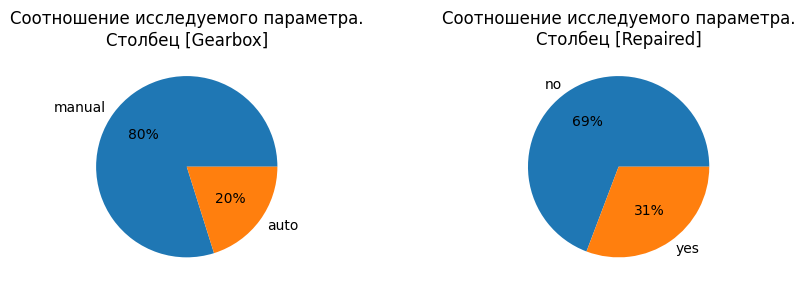

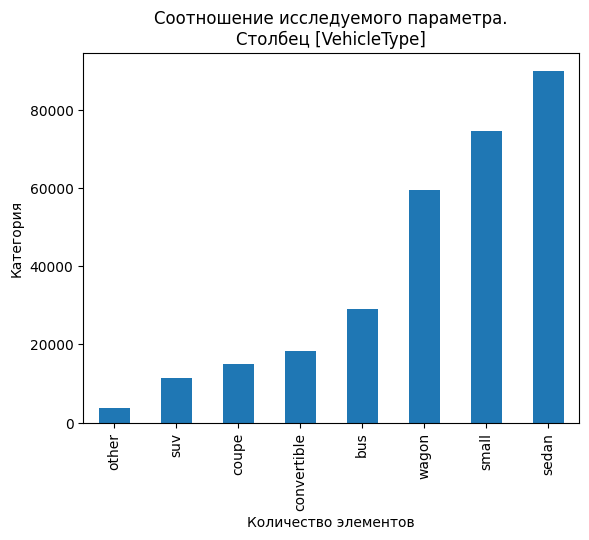

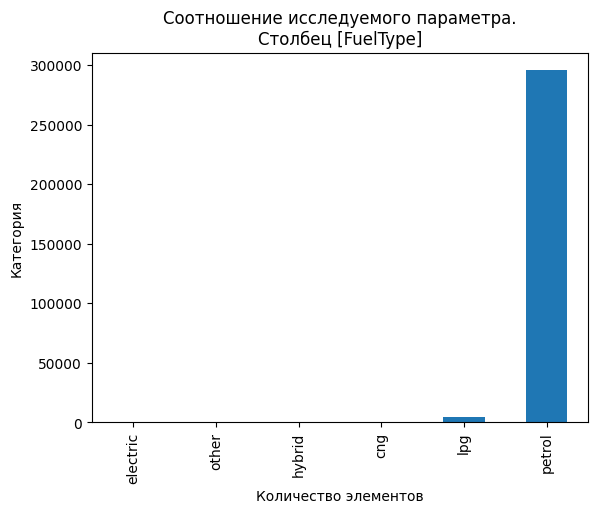

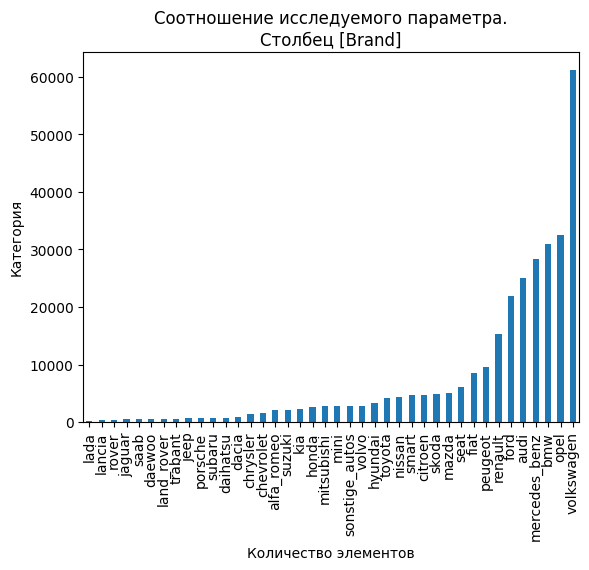

In [61]:
cat_names = [
    'VehicleType',
    'Gearbox',
    'FuelType',
    'Brand',
    'Repaired'
]

analysis_cat_cols(eda_data, cat_names)

**Промежуточный вывод**

Для всех категориальных входных признаков выявлен дисбаланс, в частности:
1. Признак `Repaired`. Автомобилей после ремонта значительно меньше.
2. Признак `Gearbox`. Также автомобилей с автоматической коробкой передач значительно меньше.
3. Признак `FuelType`. Максимально большое количество автомобилей использует безниз, некоторое количество - газ (сжиженный нефтяной или компримированный природный газ). Другие виды топлива представлены в дата-сете в минимальном количестве.
4. Признаки `VehicleType`, `Brand` и `Model` представлены весьма разнообразно.

Устранять дисбаланс входных признаков для обучения моделей устранять не будем. Для моделей регрессии дисбаланс не страшен. 

Для обучения моделей необходимо провести кодирование категориальных признаков:
1. Категориальных ранговых признаков не имеется.
2. Категориальные номинальные признаки `VehicleType`, `FuelType`, `Brand`, `Model` и бинарные `Repaired` и `Gearbox` закодируем для различных моделей с использованием различных кодеров:
    - с использованем OneHotEncoder для линейных моделей, поскольку признакам не следует придавать видимость ранговости;
    - с использованием OrdinalEncoder для моделей, не относящихся к линейным, посколько при их использовании не важны искусственные ранги категориальных признаков, а количество признаков не увеличивается, как при использовании OneHotEncoder.

### II. Исследование количественных признаков

Исследуем столбцы с количественным параметром:
- `RegistrationYear`;
- `Power`;
- `Kilometer`.

**Столбец `RegistrationYear`**

Создадим копию данных для текущего этапа

In [62]:
temp_data = eda_data.copy()

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

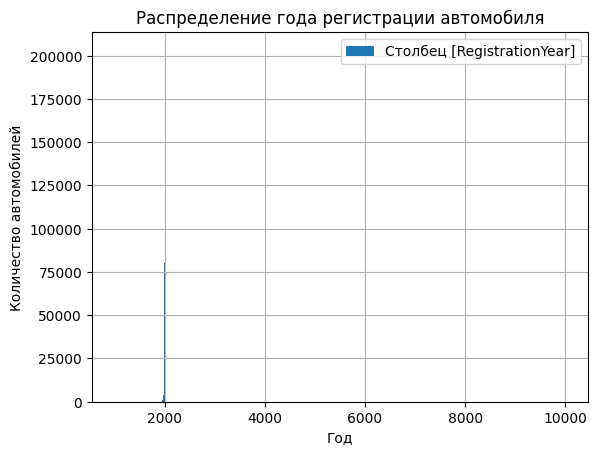


Ключевые характеристики распределения:
count    301499.00
mean       2004.41
std          93.66
min        1000.00
25%        1999.00
50%        2003.00
75%        2008.00
max        9999.00
Name: RegistrationYear, dtype: object

Ключевые характеристики диграммы размаха:
IQR			9.00
Q1-1,5*IQR		1985.50
MIN диаграммы размаха	1985.50
Q3+1,5*IQR		2021.50
MAX диаграммы размаха	2021.50



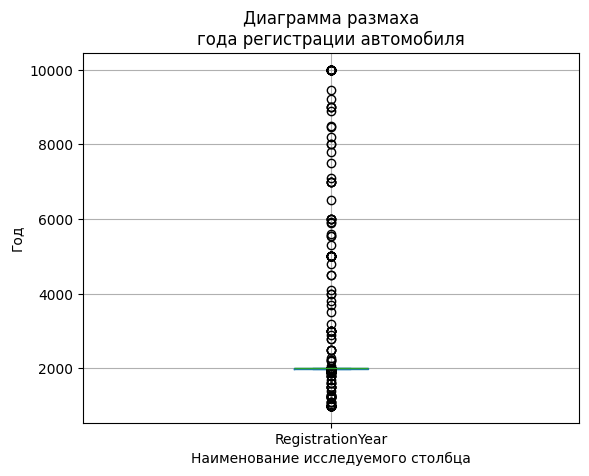

Ключевые характеристики выбросов:
Количество выбросов (вверх)	98
Доля выбросов (вверх)		0.03%
Количество выбросов (вниз)	5855
Доля выбросов (вниз)		1.94%


In [63]:
my_describe(
    temp_data, 'RegistrationYear',
    hist_desc=[
        'Распределение года регистрации автомобиля',
        'Год',
        'Количество автомобилей'
    ],
    box_desc=[
        'Диаграмма размаха\nгода регистрации автомобиля',
        'Наименование исследуемого столбца',
        'Год'
    ]
)

В результате анализа выявлено, что в столбце имеются аномальные значения признака около 10000. Необходимо проверить данные с учетом того, что все анкеты выгружены не позднее 2016 года. В таких анкетах автомобилей 2017 года регистрации и младше быть не может.

In [64]:
temp_data.query('RegistrationYear > 2016').sort_values(by='RegistrationYear', ascending=False)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
226966,50,small,9999,manual,0,other,10000,petrol,hyundai,yes
28766,7999,sedan,9999,manual,0,kaefer,10000,petrol,volkswagen,yes
17034,700,suv,9999,manual,0,other,10000,petrol,opel,yes
261071,19000,bus,9999,manual,0,transporter,10000,petrol,volkswagen,yes
200586,0,sedan,9999,manual,0,golf,10000,petrol,volkswagen,yes
...,...,...,...,...,...,...,...,...,...,...
122467,900,sedan,2017,manual,120,carisma,150000,petrol,mitsubishi,yes
122479,700,wagon,2017,manual,105,passat,150000,petrol,volkswagen,yes
122486,1050,sedan,2017,manual,133,80,150000,petrol,audi,yes
122541,750,small,2017,manual,60,polo,150000,petrol,volkswagen,no


Ошибочные записи, удалим их.

Изучим несколько самых старых автомобилей.

In [65]:
temp_data.query('RegistrationYear < 1925').sort_values(by='RegistrationYear', ascending=True)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
150302,0,bus,1000,manual,0,transporter,5000,petrol,volkswagen,yes
103090,400,sedan,1000,manual,0,c_klasse,5000,petrol,mercedes_benz,no
57640,80,sedan,1000,manual,0,golf,5000,petrol,volkswagen,yes
215656,2500,other,1000,manual,34,other,5000,petrol,sonstige_autos,yes
120534,1000,other,1000,manual,0,other,5000,petrol,sonstige_autos,yes
...,...,...,...,...,...,...,...,...,...,...
236831,0,sedan,1915,manual,0,other,125000,petrol,sonstige_autos,yes
178384,0,other,1919,manual,0,other,150000,petrol,ford,yes
246790,0,other,1920,manual,0,other,5000,other,sonstige_autos,yes
278565,8750,convertible,1923,manual,8,c3,5000,petrol,citroen,no


Теоретически, указанные автомобили могут быть раритетами, тем более очень дорогими. Особенно автомобили 1923 года выпуска. Оставим именно их и выше. Однако, сомнительными выглядят записи с нулевой и единичной ценой (целевой признак), а также нулевой мощностью. WW passat, WW beetle не могли быть зарегистрированны в 1910 году. Возможно, при отсутствии сведений от пользоваетеля о годе регистрации система автоматически устанавливает 1910 год. Удалим их

In [66]:
temp_data = temp_data.query('RegistrationYear <= 2016')
temp_data = temp_data.query('RegistrationYear >= 1923')

Применим результаты к основному дата-сету.

In [67]:
eda_data = temp_data

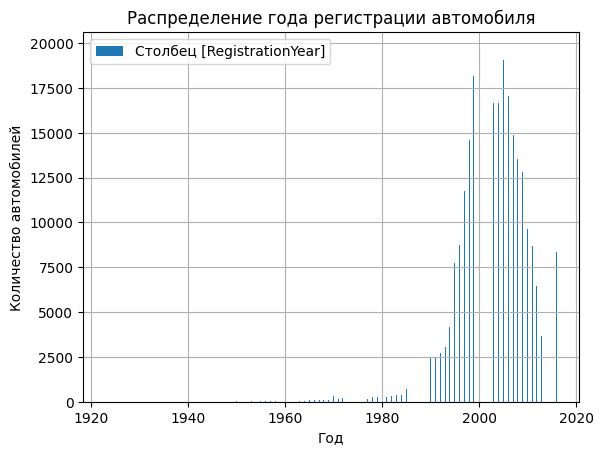


Ключевые характеристики распределения:
count    288311.00
mean       2002.57
std           7.09
min        1923.00
25%        1999.00
50%        2003.00
75%        2007.00
max        2016.00
Name: RegistrationYear, dtype: object

Ключевые характеристики диграммы размаха:
IQR			8.00
Q1-1,5*IQR		1987.00
MIN диаграммы размаха	1987.00
Q3+1,5*IQR		2019.00
MAX диаграммы размаха	2016.00



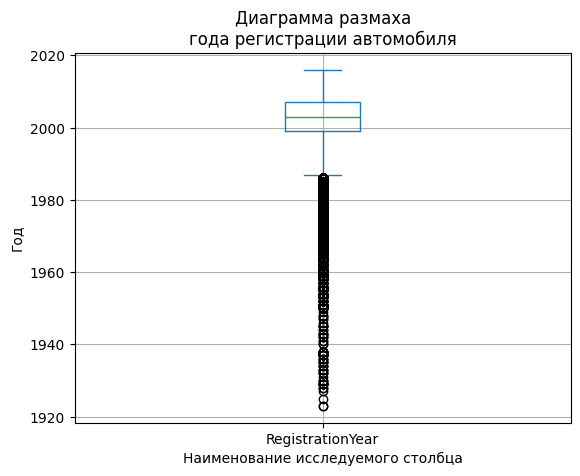

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	6222
Доля выбросов (вниз)		2.16%


In [68]:
my_describe(
    eda_data, 'RegistrationYear',
    hist_desc=[
        'Распределение года регистрации автомобиля',
        'Год',
        'Количество автомобилей'
    ],
    box_desc=[
        'Диаграмма размаха\nгода регистрации автомобиля',
        'Наименование исследуемого столбца',
        'Год'
    ]
)

Визуализируем данные для презентации

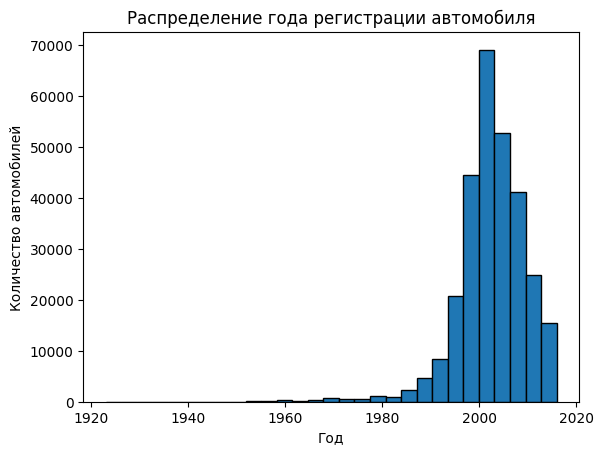

In [69]:
plt.hist(eda_data['RegistrationYear'], edgecolor='black', bins=29)
plt.title(f'Распределение года регистрации автомобиля')
plt.xlabel('Год')
plt.ylabel('Количество автомобилей')
plt.show()

_**Вывод**_

Выявлены ключевые характеристики распределения года регистрации автомобиля:

* среднее и медиана близки - 2002.57 и 2003;
* средний год регистрации 50% автомобилей в диапазоне 1999 - 2007;
* минимальное значение - 1923 (раритеты не удалялиь), максимальное - 2016.
    
Распределение года регистрации визуально представляет собой распределение Пуассона.

**Столбец `Power`**

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

Создадим копию данных для текущего этапа

In [70]:
temp_data = eda_data.reset_index(drop=True).copy()

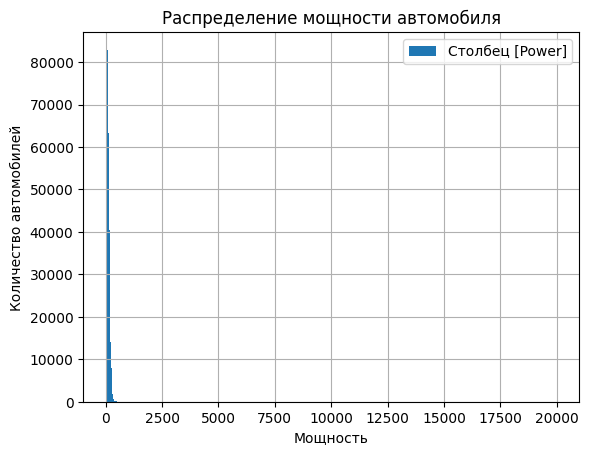


Ключевые характеристики распределения:
count    288311.00
mean        113.15
std         200.18
min           0.00
25%          71.00
50%         105.00
75%         143.00
max       20000.00
Name: Power, dtype: object

Ключевые характеристики диграммы размаха:
IQR			72.00
Q1-1,5*IQR		-37.00
MIN диаграммы размаха	0.00
Q3+1,5*IQR		251.00
MAX диаграммы размаха	251.00



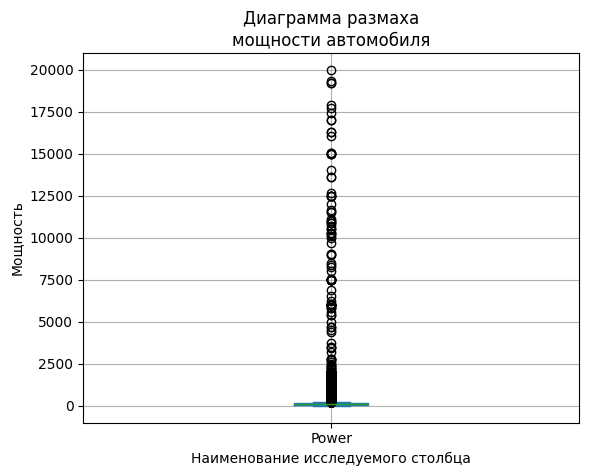

Ключевые характеристики выбросов:
Количество выбросов (вверх)	6563
Доля выбросов (вверх)		2.28%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [71]:
my_describe(
    temp_data, 'Power',
    hist_desc=[
        'Распределение мощности автомобиля',
        'Мощность',
        'Количество автомобилей'
    ],
    box_desc=[
        'Диаграмма размаха\nмощности автомобиля',
        'Наименование исследуемого столбца',
        'Мощность'
    ]
)

В данных имеются автомобили с нулевой и единичной мощностью. Изучим их.

In [72]:
temp_data.query('Power == 0')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,480,sedan,1993,manual,0,golf,150000,petrol,volkswagen,yes
29,245,sedan,1994,manual,0,golf,150000,petrol,volkswagen,no
34,1500,bus,2016,manual,0,kangoo,150000,petrol,renault,no
37,0,small,1990,manual,0,corsa,150000,petrol,opel,yes
49,4700,wagon,2005,manual,0,signum,150000,petrol,opel,no
...,...,...,...,...,...,...,...,...,...,...
288288,390,small,1997,auto,0,corsa,100000,petrol,opel,yes
288289,180,small,1995,manual,0,corsa,125000,petrol,opel,yes
288294,2600,sedan,2005,auto,0,c_klasse,150000,petrol,mercedes_benz,yes
288306,0,sedan,2005,manual,0,colt,150000,petrol,mitsubishi,yes


Очень много записей с нулевой мощностью. Однако, признак не категориальный, много нулевых значений повлияет на качество обучения. Исключим их.

In [73]:
temp_data = temp_data.query('Power != 0')

Рассмотрим записи с самыми низкими значениями Power

In [74]:
temp_data.query('Power < 15').sort_values(by='Power', ascending=True)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
133482,1,sedan,1994,manual,1,astra,150000,petrol,opel,yes
76712,0,wagon,2003,manual,1,mondeo,150000,petrol,ford,yes
48862,990,coupe,1974,manual,1,kadett,5000,petrol,opel,yes
30966,3900,convertible,2004,auto,1,forfour,90000,petrol,smart,no
263580,199,suv,2005,manual,1,other,90000,other,sonstige_autos,no
...,...,...,...,...,...,...,...,...,...,...
110407,11800,coupe,1961,manual,14,other,30000,petrol,sonstige_autos,yes
184593,1111,small,1991,manual,14,panda,100000,petrol,fiat,no
151427,2200,coupe,1965,manual,14,other,150000,petrol,sonstige_autos,no
95728,8300,sedan,2009,manual,14,polo,80000,petrol,volkswagen,no


Значения 1 для выглядят очень сомнительно.

In [75]:
temp_data.query('Power == 15').sort_values(by='RegistrationYear', ascending=True)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
121673,11500,convertible,1929,manual,15,other,5000,petrol,bmw,yes
81819,15800,small,1960,manual,15,500,70000,petrol,fiat,no
121492,14000,small,1962,manual,15,other,10000,petrol,citroen,no
258448,15000,convertible,1973,manual,15,other,5000,petrol,lancia,yes
141837,500,small,1990,manual,15,punto,5000,petrol,fiat,no
206689,1,sedan,1995,manual,15,3er,5000,petrol,bmw,yes
231390,3400,small,1996,manual,15,500,150000,petrol,fiat,yes
126775,3896,other,1999,manual,15,other,30000,petrol,sonstige_autos,no
91410,3599,wagon,2003,auto,15,3er,150000,petrol,bmw,yes
53933,2799,other,2006,auto,15,other,10000,petrol,sonstige_autos,yes


В то же время BMW 1929 года выпуска convertible вполне возможна. Оставим данные. Мы не можем быть уверенными без изучения каждого автомобиля в отдельности. В данных имеются автомобили с мощностью до раритетных 8-18 л.с., которые были обнаружены ранее. Не будем их удалять, хотя они и могут повлиять на результаты обучения.

Большая часть автомобилей (75%) имеет мощность не более 146 л.с. Очень странно выглядят значения мощности более 1500 л.с. (на 2016 год (год сбора дата-сета) самый мощный автомобиль - Koenigsegg Regera, 2016 г.в., 1119 кВт (1500 л.с.; 1521 л.с.)). Непонятно, в каких единицах измерения могли быть указаны данные значения. Без эксперта исправить данные не представляется возможным. Для приведения данных к единому формату все выбросы будут удалены. 

In [76]:
temp_data.query('Power >= 1500').sort_values(by='Power', ascending=True)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
190681,1600,sedan,1998,manual,1500,passat,150000,petrol,volkswagen,no
173235,1400,sedan,1998,manual,1500,5er,150000,petrol,bmw,yes
203689,1500,sedan,1998,manual,1500,3er,150000,petrol,bmw,yes
71181,4700,wagon,2004,auto,1500,3er,150000,petrol,bmw,no
90072,1500,wagon,2000,manual,1501,passat,150000,lpg,volkswagen,yes
...,...,...,...,...,...,...,...,...,...,...
58727,3250,sedan,2001,auto,17932,omega,150000,petrol,opel,yes
117610,2100,wagon,2001,manual,19208,5er,150000,petrol,bmw,yes
102092,9999,sedan,2006,manual,19211,1er,125000,petrol,bmw,yes
248185,1500,wagon,1997,manual,19312,5er,150000,petrol,bmw,no


Попробуем найти среди автомобилей с мощностью более 650 л.с. (Porsche Turbo S 3.8 AMT 4WD) известные марки.

In [77]:
temp_data.query('Power >= 650')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1732,3200,small,2004,manual,1398,corolla,5000,petrol,toyota,no
2009,0,sedan,1999,manual,1799,vectra,150000,petrol,opel,yes
3871,3100,sedan,2005,manual,953,colt,150000,petrol,mitsubishi,no
5058,500,wagon,1999,manual,1001,astra,150000,petrol,opel,yes
6167,3000,small,2009,manual,771,punto,125000,petrol,fiat,yes
...,...,...,...,...,...,...,...,...,...,...
284209,1000,wagon,1996,manual,2598,a6,150000,petrol,audi,yes
284360,7500,sedan,2011,manual,1548,scenic,90000,petrol,renault,yes
284417,250,small,1999,manual,1241,ypsilon,150000,petrol,lancia,yes
286541,1500,bus,2001,manual,1001,zafira,5000,petrol,opel,no


In [78]:
temp_data.query('Power >= 650')['Brand'].unique()

array(['toyota', 'opel', 'mitsubishi', 'fiat', 'volkswagen', 'honda',
       'ford', 'seat', 'bmw', 'nissan', 'mercedes_benz', 'citroen',
       'lancia', 'skoda', 'volvo', 'chevrolet', 'peugeot', 'smart',
       'audi', 'sonstige_autos', 'kia', 'renault', 'chrysler', 'mazda',
       'suzuki', 'mini', 'alfa_romeo', 'daewoo', 'hyundai'], dtype=object)

In [79]:
top_list = ['bmw', 'mercedes_benz', 'toyota', 'audi', 'nissan', 'sonstige_autos', 'mitsubishi']
temp_data.query('Power >= 1500').query('Brand in @top_list')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
17986,9750,wagon,2005,auto,2729,5er,150000,petrol,bmw,no
18882,2200,sedan,2002,auto,1704,e_klasse,150000,petrol,mercedes_benz,yes
20940,3999,sedan,1998,manual,1993,3er,150000,cng,bmw,yes
31638,3740,small,2006,manual,6920,aygo,90000,petrol,toyota,no
52702,3990,wagon,2003,manual,1796,c_klasse,150000,petrol,mercedes_benz,no
...,...,...,...,...,...,...,...,...,...,...
268746,12000,wagon,2008,manual,1700,c_klasse,150000,petrol,mercedes_benz,no
276597,1700,wagon,1995,manual,1503,a4,150000,petrol,audi,no
278898,10000,wagon,2005,auto,1631,a4,150000,petrol,audi,yes
282739,1300,sedan,2000,manual,12512,carisma,150000,petrol,mitsubishi,yes


Ни один из представленных автомобилей не может иметь такой мощности (даже неизвестные sonstige_autos). Считаем, что данные значения аномальны.

In [80]:
temp_data = temp_data.query('Power < 650')

Рассмотрим самые быстрые автомобили

In [81]:
temp_data.query('Power >= 550').sort_values(by='Power', ascending=False)

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
210593,1250,suv,1987,manual,645,other,150000,petrol,suzuki,yes
150225,18000,coupe,1997,manual,640,golf,125000,petrol,volkswagen,yes
7628,500,small,2002,manual,620,ypsilon,150000,petrol,lancia,yes
159910,17000,sedan,2004,auto,620,e_klasse,150000,petrol,mercedes_benz,yes
128740,2700,small,2004,auto,612,fortwo,125000,petrol,smart,yes
21756,400,wagon,2015,auto,610,other,5000,petrol,audi,yes
124271,590,small,2016,manual,606,polo,150000,petrol,volkswagen,yes
33529,250,sedan,2016,manual,606,golf,150000,petrol,volkswagen,yes
154513,600,small,1997,auto,606,corsa,150000,petrol,opel,no
183799,3890,sedan,2009,manual,604,corsa,90000,petrol,opel,yes


Действительно, ряд автомобилей марок jaguar, nissan, mercedes_benz, suzuki могут иметь соответствующие показатели мощности. Однако, и их стоимость будет высока. Стоимость автомобиля с мощностью более 600 л.с. не может стоить меньше 10000 евро. Считаем такие автомобили аномалиями.

In [82]:
temp_data = temp_data.query('Power <= 600')

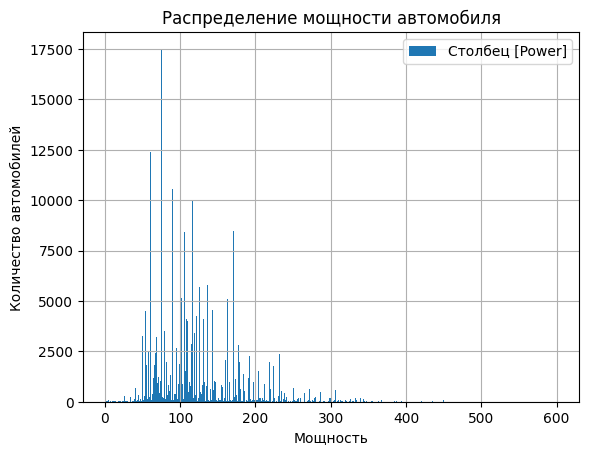


Ключевые характеристики распределения:
count    257722.00
mean        121.95
std          54.36
min           1.00
25%          80.00
50%         115.00
75%         150.00
max         600.00
Name: Power, dtype: object

Ключевые характеристики диграммы размаха:
IQR			70.00
Q1-1,5*IQR		-25.00
MIN диаграммы размаха	1.00
Q3+1,5*IQR		255.00
MAX диаграммы размаха	255.00



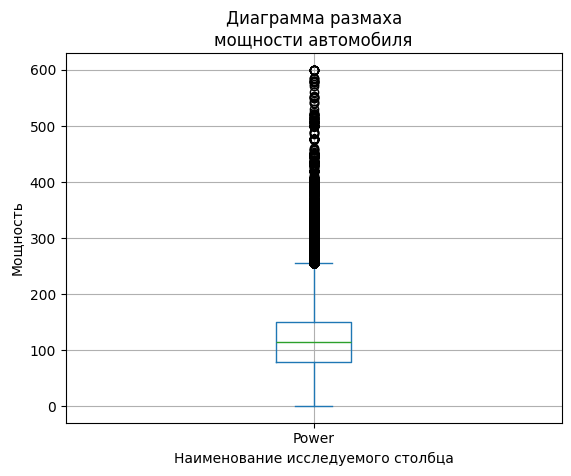

Ключевые характеристики выбросов:
Количество выбросов (вверх)	6110
Доля выбросов (вверх)		2.37%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [83]:
my_describe(
    temp_data, 'Power',
    hist_desc=[
        'Распределение мощности автомобиля',
        'Мощность',
        'Количество автомобилей'
    ],
    box_desc=[
        'Диаграмма размаха\nмощности автомобиля',
        'Наименование исследуемого столбца',
        'Мощность'
    ]
)

Применим результаты к основному дата-сету.

In [84]:
eda_data = temp_data.copy()

Визуализируем данные для презентации

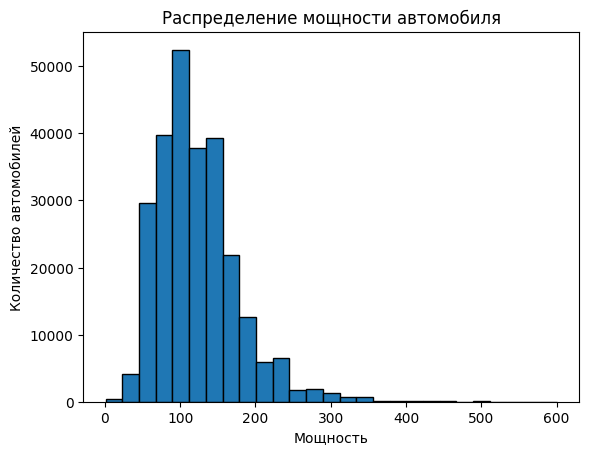

In [85]:
plt.hist(eda_data['Power'], edgecolor='black', bins=27)
plt.title(f'Распределение мощности автомобиля')
plt.xlabel('Мощность')
plt.ylabel('Количество автомобилей')
plt.show()

_**Вывод**_

Выявлены ключевые характеристики распределения мощности автомобилей:

* среднее и медиана близки - 121.95 и 115;
* средная мощность 50% автомобилей в диапазоне 80.00 - 150.00;
* минимальное значение - 1 л.с. (возможно, это единичные ошибки в данных), максимальное - 600 л.с.
    
Распределение мощности визуально представляет собой распределение Пуассона.

**Столбец `Kilometer`**

Создадим копию данных для текущего этапа

In [86]:
temp_data = eda_data.reset_index(drop=True).copy()

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

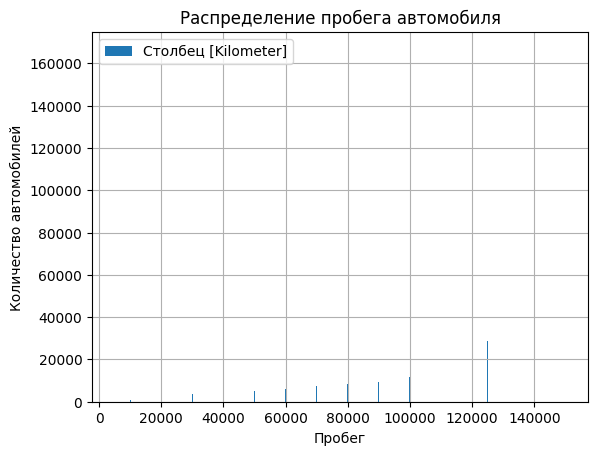


Ключевые характеристики распределения:
count    257722.00
mean     126980.66
std       37725.70
min        5000.00
25%      125000.00
50%      150000.00
75%      150000.00
max      150000.00
Name: Kilometer, dtype: object

Ключевые характеристики диграммы размаха:
IQR			25000.00
Q1-1,5*IQR		87500.00
MIN диаграммы размаха	87500.00
Q3+1,5*IQR		187500.00
MAX диаграммы размаха	150000.00



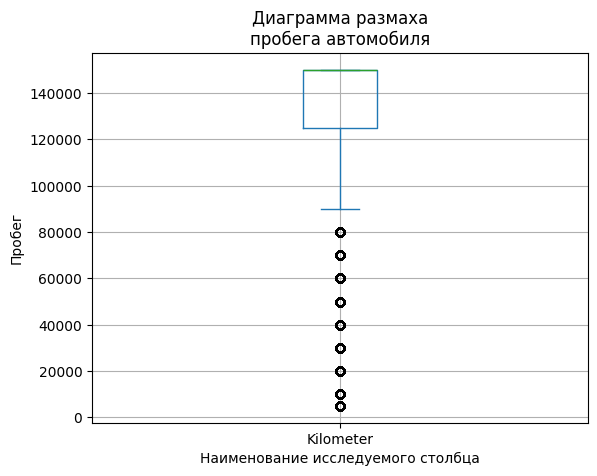

Ключевые характеристики выбросов:
Количество выбросов (вверх)	0
Доля выбросов (вверх)		0.00%
Количество выбросов (вниз)	41419
Доля выбросов (вниз)		16.07%


In [87]:
my_describe(
    temp_data, 'Kilometer',
    hist_desc=[
        'Распределение пробега автомобиля',
        'Пробег',
        'Количество автомобилей'
    ],
    box_desc=[
        'Диаграмма размаха\nпробега автомобиля',
        'Наименование исследуемого столбца',
        'Пробег'
    ]
)

Выявлены возможные выбросы вниз. Изучим их.

In [88]:
temp_data.query('Kilometer < 25000')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
24,1990,bus,1981,manual,50,transporter,5000,petrol,volkswagen,no
28,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no
43,1400,small,2016,manual,55,other,5000,petrol,hyundai,yes
126,6799,small,2009,manual,60,golf,20000,petrol,volkswagen,no
130,7500,suv,2007,auto,194,sorento,5000,petrol,kia,yes
...,...,...,...,...,...,...,...,...,...,...
257380,12700,small,2015,manual,60,polo,20000,petrol,volkswagen,no
257512,10500,convertible,1968,manual,54,other,20000,petrol,renault,no
257543,10985,small,2015,manual,82,1_reihe,5000,petrol,peugeot,no
257587,0,small,2000,manual,55,punto,5000,petrol,fiat,yes


Указаные записи не представляются аномальными. Не будем их исключать.

Применим результаты к основному дата-сету.

In [89]:
eda_data = temp_data.copy()

Данные очень похожи на дискретный признак. Изучим уникальные значения.

In [90]:
eda_data['Kilometer'].unique()

array([125000, 150000,  90000,  40000,  30000,  70000, 100000,  60000,
         5000,  20000,  80000,  50000,  10000], dtype=int64)

Так и есть. Признак, фактически, оказался категориальным.

Визуализируем данные для презентации

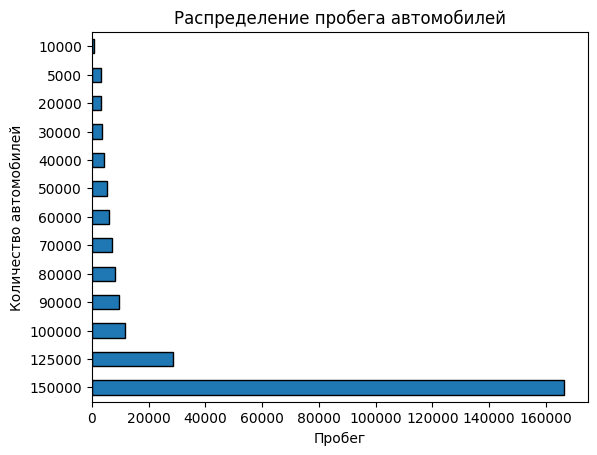

In [91]:
eda_data['Kilometer'].value_counts(ascending=False).plot(
        kind = 'barh', 
        edgecolor='black',
        rot=0
    )   
plt.title(
    'Распределение пробега автомобилей'
)
plt.ylabel('Количество автомобилей')
plt.xlabel('Пробег')
plt.show()

_**Вывод**_

В результате анализа выявлено, что признак носит категориальный характер. Больше всего автомобилей имеют пробег около 150 000 км. Меньше всего - автомобилей с минимальным пробегом около 10000. Чуть больше новых автомобилей.

При обучении моделей закодируем указанный признак с использованием OrdinalEncoder, чтобы не увеличивать количество признаков, а также в связи с тем, что ранговость указанного признака может иметь влияние на целевой признак.

**Столбец `Price`**

Создадим копию данных для текущего этапа

In [92]:
temp_data = eda_data.reset_index(drop=True).copy()

В рассматриваемом столбце представлены значения количественного дискретного параметра. Выведем основные характеристики для анализа с использованием созданной функции для всех таблиц.

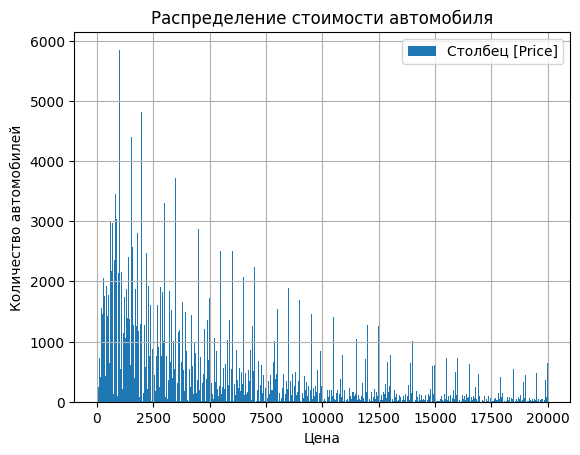


Ключевые характеристики распределения:
count    257722.00
mean       4897.76
std        4679.83
min           0.00
25%        1300.00
50%        3200.00
75%        7000.00
max       20000.00
Name: Price, dtype: object

Ключевые характеристики диграммы размаха:
IQR			5700.00
Q1-1,5*IQR		-7250.00
MIN диаграммы размаха	0.00
Q3+1,5*IQR		15550.00
MAX диаграммы размаха	15550.00



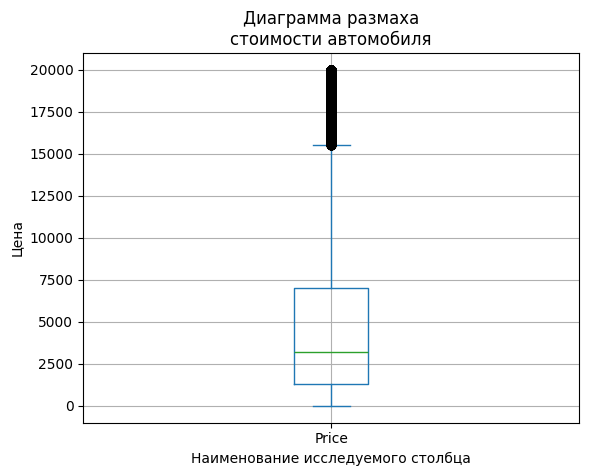

Ключевые характеристики выбросов:
Количество выбросов (вверх)	11680
Доля выбросов (вверх)		4.53%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [93]:
my_describe(
    temp_data, 'Price',
    hist_desc=[
        'Распределение стоимости автомобиля',
        'Цена',
        'Количество автомобилей'
    ],
    box_desc=[
        'Диаграмма размаха\nстоимости автомобиля',
        'Наименование исследуемого столбца',
        'Цена'
    ]
)

Выявлены возможные выбросы вверх. Изучим их.

In [94]:
temp_data.query('Price > 17350')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
0,18300,coupe,2011,manual,190,a4,125000,petrol,audi,yes
13,17999,suv,2011,manual,190,navara,70000,petrol,nissan,no
28,18000,sedan,2007,auto,218,3er,20000,petrol,bmw,no
140,19750,convertible,2006,manual,305,mustang,50000,petrol,ford,no
167,18400,wagon,2011,auto,313,5er,150000,petrol,bmw,no
...,...,...,...,...,...,...,...,...,...,...
257480,17999,coupe,2002,manual,343,m_reihe,150000,petrol,bmw,no
257518,20000,coupe,2006,auto,476,other,125000,petrol,mercedes_benz,no
257563,17890,wagon,2011,auto,160,insignia,100000,petrol,opel,no
257602,19990,small,2014,auto,185,a1,10000,petrol,audi,no


Указаные записи не представляются аномальными, по первым пяти можно предположить, что мощные не самые старые автомобили могут иметь стоимость более 17000 евро. Не будем их исключать.

При этом, минимальное значение стоимости автомобилей - 0. Полагаем целесообразным изучить записи с ценой менее 1000 евро.

In [95]:
temp_data.query('Price < 1000')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
4,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
8,999,small,1998,manual,101,golf,150000,petrol,volkswagen,yes
11,999,wagon,1995,manual,115,passat,150000,petrol,volkswagen,yes
14,300,small,2016,manual,60,polo,150000,petrol,volkswagen,yes
...,...,...,...,...,...,...,...,...,...,...
257683,850,sedan,1989,manual,113,80,150000,petrol,audi,yes
257686,99,small,1999,manual,60,arosa,150000,petrol,seat,yes
257700,350,small,1996,manual,65,punto,150000,petrol,fiat,yes
257708,800,wagon,2000,manual,101,astra,150000,petrol,opel,yes


Старые автомобили с большим пробегом могут стоить менее 450 евро. Снижаем планку для анализа.

In [96]:
temp_data.query('Price < 450')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
6,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
14,300,small,2016,manual,60,polo,150000,petrol,volkswagen,yes
30,350,sedan,2016,manual,75,golf,150000,petrol,volkswagen,no
47,1,suv,1994,manual,286,other,150000,petrol,sonstige_autos,yes
48,200,coupe,1995,manual,102,3er,150000,petrol,bmw,yes
...,...,...,...,...,...,...,...,...,...,...
257664,150,small,1993,manual,55,astra,150000,petrol,opel,yes
257667,0,small,1999,manual,37,arosa,150000,petrol,seat,yes
257679,400,wagon,1996,manual,150,a4,150000,petrol,audi,yes
257686,99,small,1999,manual,60,arosa,150000,petrol,seat,yes


Автомобили после ремонта могут быть не на ходу и продаваться очень дешево. Снижаем планку для анализа значением в 100 евро.

In [97]:
temp_data.query('Price < 100')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
6,0,sedan,1980,manual,50,other,40000,petrol,volkswagen,no
47,1,suv,1994,manual,286,other,150000,petrol,sonstige_autos,yes
74,1,sedan,1995,manual,113,e_klasse,150000,petrol,mercedes_benz,no
127,0,bus,2004,manual,101,meriva,150000,lpg,opel,yes
192,0,wagon,2001,manual,115,mondeo,150000,petrol,ford,yes
...,...,...,...,...,...,...,...,...,...,...
257587,0,small,2000,manual,55,punto,5000,petrol,fiat,yes
257637,0,small,2002,manual,60,fiesta,150000,petrol,ford,yes
257646,0,small,1999,manual,53,swift,150000,petrol,suzuki,yes
257667,0,small,1999,manual,37,arosa,150000,petrol,seat,yes


Почти все нули и единицы. Их предлагается исключить из рассмотрения.

In [98]:
temp_data = temp_data.query('Price > 1')

Повторим анализ

In [99]:
temp_data.query('Price < 100')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
796,98,small,1997,manual,53,swift,150000,petrol,suzuki,no
869,3,convertible,1998,manual,110,mx_reihe,150000,petrol,mazda,yes
1375,2,bus,2004,manual,135,scenic,150000,petrol,renault,yes
2279,80,small,2001,manual,98,rio,150000,petrol,kia,yes
2586,30,sedan,1995,manual,75,polo,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
254275,10,small,1999,manual,75,golf,150000,petrol,volkswagen,no
255813,20,small,1970,manual,55,corsa,150000,petrol,opel,yes
256841,30,sedan,2016,manual,75,golf,150000,petrol,volkswagen,yes
257273,90,small,1998,manual,60,other,150000,petrol,citroen,yes


Все указанные записи предлагается удалить. Возможно для некотокрых автомобилей указаны неверные стоимости (забыты нули).

In [100]:
temp_data = temp_data.query('Price > 100')

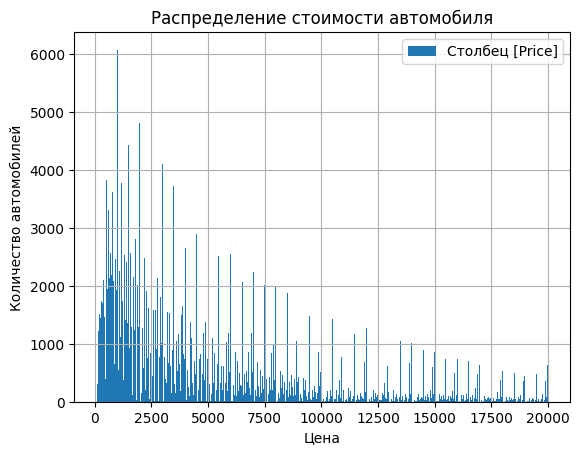


Ключевые характеристики распределения:
count    251076.00
mean       5027.07
std        4672.47
min         101.00
25%        1450.00
50%        3400.00
75%        7290.00
max       20000.00
Name: Price, dtype: object

Ключевые характеристики диграммы размаха:
IQR			5840.00
Q1-1,5*IQR		-7310.00
MIN диаграммы размаха	101.00
Q3+1,5*IQR		16050.00
MAX диаграммы размаха	16050.00



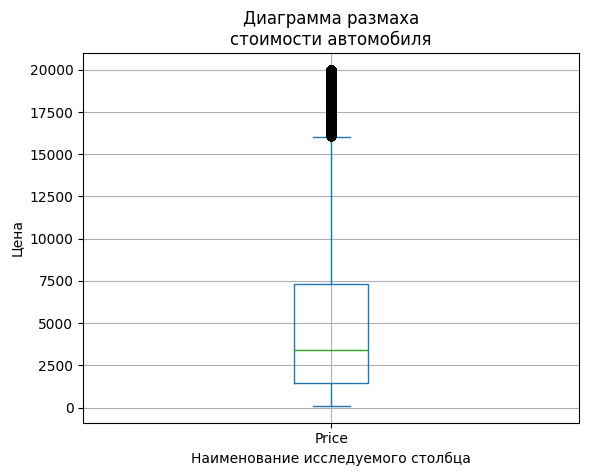

Ключевые характеристики выбросов:
Количество выбросов (вверх)	9772
Доля выбросов (вверх)		3.89%
Количество выбросов (вниз)	0
Доля выбросов (вниз)		0.00%


In [101]:
my_describe(
    temp_data, 'Price',
    hist_desc=[
        'Распределение стоимости автомобиля',
        'Цена',
        'Количество автомобилей'
    ],
    box_desc=[
        'Диаграмма размаха\nстоимости автомобиля',
        'Наименование исследуемого столбца',
        'Цена'
    ]
)

Применим результаты к основному дата-сету.

In [102]:
eda_data = temp_data.reset_index(drop=True).copy()

Визуализируем данные для презентации

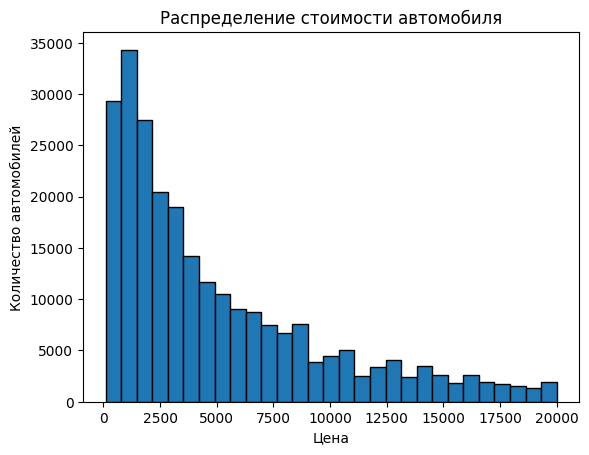

In [103]:
plt.hist(eda_data['Price'], edgecolor='black', bins=29)
plt.title(f'Распределение стоимости автомобиля')
plt.xlabel('Цена')
plt.ylabel('Количество автомобилей')
plt.show()

_**Вывод**_

Выявлены ключевые характеристики распределения мощности автомобилей:
* среднее и медиана не близки - 5027.07 и 3400.00;
* средная мощность 50% автомобилей в диапазоне 1450.00 - 7290.00;
* минимальное значение - 101.00, максимальное - 20000.00.
    
Распределение года регистрации визуально представляет собой распределение Пуассона.

**Промежуточный вывод**

Для всех количественных входных признаков проведен исследовательский анализ и выявлено:
1. В данных были обнаружены возможные выбросы (статистическим методом), однако не похожие на аномалии. В связи с этим, выбросы не удалялись. При этом, найдены ошибки в данных, связанные с наличием нулевых значений, минимальных единичных значений.

2. Выявлено, что признак `Kilometer` носит категориальный характер. Больше всего автомобилей имеют пробег около 150 000 км. Меньше всего - автомобилей с минимальным пробегом около 10000. Чуть больше новых автомобилей. При обучении моделей закодируем указанный признак с использованием OrdinalEncoder, чтобы не увеличивать количество признаков, а также в связи с тем, что ранговость указанного признака может иметь влияние на целевой признак.

3. Ключевые характеристики количественных признаков:
    - `RegistrationYear` - медиана 2004 год, 50% автомобилей в диапазоне 1999-2007 годы, минимум - 1910 год (раритеты не удалялись), максимум - 2018. Распределение признака визуально представляет собой распределение Пуассона.
    - `Power` - медиана 116.0 л.с., 50% автомобилей в диапазоне 86.00 л.с. - 150.00 л.с., минимум - 1 л.с., максимум - 600 л.с. Распределение признака визуально представляет собой распределение Пуассона.

4. Ключевые характеристики целевого признака:
    - `Price` - медиана 3850.00, 50% автомобилей в диапазоне 1690.00 - 7950.00, минимум - 101, максимум - 20000.00. Распределение признака визуально представляет собой распределение Пуассона.
    
    Кроме того, у целевого признака выявлена очень высокая дисперсия (стандартное отклонение - 4690.46 при среднем 5109.62). Необходимо учесть этот фактор при выборе метрики для оценки качества обучения.

5. Для корректного обучения моделей полагаем целесообразным провести масштабирование количественных признаков в связи с большой разницей в мастшатах (отличие `RegistrationYear` и `Power` в 3-20 раз). При обучении моделей используем несколько объектов scaler - StandardScaler(), RobustScaler().

### Корреляционный анализ

Предварительно создадим копию данных для текущего этапа работы.

In [104]:
corr_data = eda_data.copy()

В рамках корреляционного анализа признаков будем коэффициент корреляции ϕk для оценки связи категориальных признаков и количественных дискретных признаков, в том числе целевого.

Проверим наличие мультиколлинеарности между признаками. Мультикорреальность будем оценивать при коэффициенте корреляции от 0.9 до 1 (очень высокая связь по шкале Чеддока).

Для анализа применим созданные функции.

Построим матрицы корреляции между количественными и категориальными признаками.

In [105]:
# Определим типы признаков
cat_corr = [
    'VehicleType',
    'Gearbox',
    'FuelType',
    'Brand',
    'Model',
    'Repaired',
    'Kilometer'
]

num_corr = [
    'Power',
    'RegistrationYear',
]

target = 'Price'

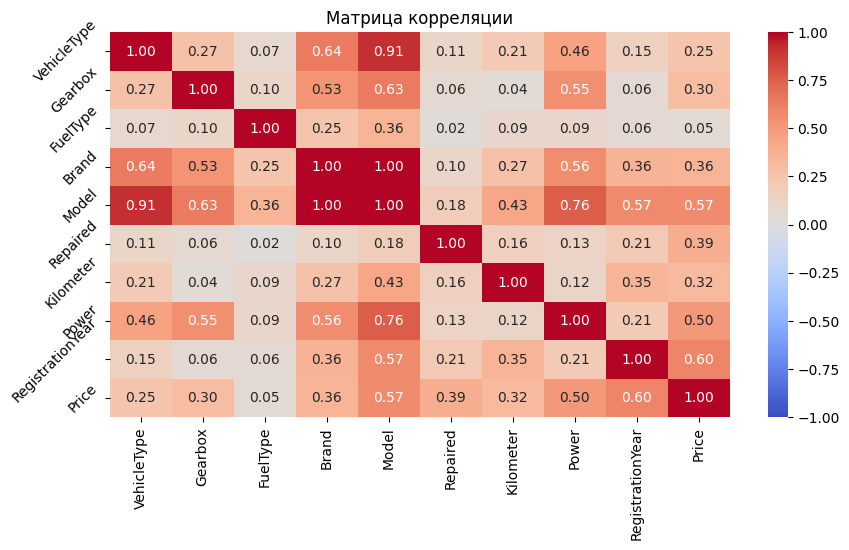

In [106]:
corr_matrix(
    corr_data,
    cat_corr + num_corr,
    'phik',
    target=target,
    interval_cols=[
        'Power', 
        'RegistrationYear',
        'Price'
    ]
)

**Промежуточный вывод**

Очень сильной зависимости между входными признаками и целевым не выявлено.
При этом, заметна очень сильная зависимость двух входных признаков (мультиколлинеарность): `VehicleType` и `Model`. Большая линейная зависимость с целевым признаком выявляется у входного признака `Model`. При разработке моделей МО учтем эту мультиколлинеарность и, при необходимости, удалим признак `VehicleType`, для линейных моделей.

Однако, между следующими парами признаков имеется некоторая линейная связь:
- `VehicleType` и `Brand`;
- `Power` и `VehicleType`, `Model`, `Gearbox` и др.
Указанные зависимости логичны. Данные зависимости могут повлиять на обучение моделей, особенно, линейных.

На целевой признак многие признаки влияют в некоторой степени линейно (значения коэффициентов от 0,3 до 0,6).

### Вывод по разделу "Исследовательский анализ данных" 

<a id='conclusion13' />

[Вернуться к началу](#begin)

В результате проведения исследовательского анализа были выявлены следующие факторы, влияющие на достижение цели работы.

1. Для всех категориальных входных признаков выявлен дисбаланс, который может оказать влияние на результаты анализа данных, в частности:
    1. Признак `Repaired`. Автомобилей после ремонта значительно меньше.
    2. Признак `Gearbox`. Также автомобилей с автоматической коробкой передач значительно меньше.
    3. Признак `FuelType`. Максимально большое количество автомобилей использует безниз, некоторое количество - газ (сжиженный нефтяной или компримированный природный газ). Другие виды топлива представлены в дата-сете в минимальном количестве.
    4. Признаки `VehicleType`, `Brand` и `Model` представлены весьма разнообразно.
      
    Устранять дисбаланс входных признаков для обучения моделей устранять не будем. Для моделей регрессии дисбаланс не страшен. 

    Для обучения моделей необходимо провести кодирование категориальных признаков:
    1. Категориальных ранговых признаков не имеется.
    2. Категориальные номинальные признаки `VehicleType`, `FuelType`, `Brand`, `Model` и бинарные `Repaired` и `Gearbox` закодируем для различных моделей с использованием различных кодеров:
        - с использованем OneHotEncoder для линейных моделей, поскольку признакам не следует придавать видимость ранговости;
        - с использованием OrdinalEncoder для моделей, не относящихся к линейным, посколько при их использовании не важны искусственные ранги категориальных признаков, а количество признаков не увеличивается, как при использовании OneHotEncoder.


2. Для всех количественных входных признаков проведен исследовательский анализ и выявлено:
    
    1. В данных были обнаружены возможные выбросы (статистическим методом), однако не похожие на аномалии. В связи с этим, выбросы не удалялись. При этом, найдены ошибки в данных, связанные с наличием нулевых значений, минимальных единичных значений.

    2. Выявлено, что признак `Kilometer` носит категориальный характер. Больше всего автомобилей имеют пробег около 150 000 км. Меньше всего - автомобилей с минимальным пробегом около 10000. Чуть больше новых автомобилей. При обучении моделей закодируем указанный признак с использованием OrdinalEncoder, чтобы не увеличивать количество признаков, а также в связи с тем, что ранговость указанного признака может иметь влияние на целевой признак.

    3. Ключевые характеристики количественных признаков:
        - `RegistrationYear` - медиана 2003 год, 50% автомобилей в диапазоне 1999-2007 годы, минимум - 1923 год (раритеты не удалялись), максимум - 2016. Распределение признака визуально представляет собой распределение Пуассона.
        - `Power` - медиана 115.0 л.с., 50% автомобилей в диапазоне 80.00 л.с. - 150.00 л.с., минимум - 1 л.с., максимум - 600 л.с. Распределение признака визуально представляет собой распределение Пуассона.

    4. Ключевые характеристики целевого признака:
        - `Price` - медиана 3400.00, 50% автомобилей в диапазоне 1450.00 - 7290.00, минимум - 101, максимум - 20000.00. Распределение признака визуально представляет собой распределение Пуассона.

    3. Для корректного обучения моделей полагаем целесообразным провести масштабирование количественных признаков в связи с большой разницей в мастшатах (отличие `RegistrationYear` и `Power` в 3-20 раз). При обучении моделей используем несколько объектов scaler - StandardScaler(), RobustScaler().
    
3. Проведен корреляционный анализ данных. Очень сильной зависимости между входными признаками и целевым не выявлено. При этом, заметна очень сильная зависимость двух входных признаков (мультиколлинеарность): `VehicleType` и `Model`. Большая линейная зависимость с целевым признаком выявляется у входного признака `Model`. При разработке модлей МО учтем эту мультиколлинеарность и, при необходимости, удалим признак `VehicleType`, для линейных моделей.

    Однако, между следующими парами признаков имеется некоторая линейная связь:
    - `VehicleType` и `Brand`;
    - `Power` и `VehicleType`, `Model`, `Gearbox` и др.
    Указанные зависимости логичны. Данные зависимости могут повлиять на обучение моделей, особенно, линейных.

    На целевой признак многие признаки влияют в некоторой степени линейно (значения коэффициентов от 0,3 до 0,6).

## Подготовка данных 

<a id='step14' />

[Вернуться к началу](#begin)

Отметим, что на предыдущих этапах работы не сделаны предложения по объединению или разделению необходимых данных в единый или различные дата-сеты, формированию новых признаков, дополнительных категорий и групп данных.

В связи с этим, осуществиим подготовку данных для формирования моделей МО и их обучения на основе pipeline с учетом ключевых действия по подготовке данных, определенных в результате предыдущих шагов работы.

Также подготовим дата-сеты для обучения: тренировочную, валидационную и тестовую выборки.

Предварительно создадим копию входных данных для текущего этапа работы.

In [107]:
process_data = corr_data.reset_index(drop=True).copy()

Определим способы кодирования

In [108]:
categorical_features = [
    'VehicleType',
    'Gearbox',
    'FuelType',
    'Brand',
    'Model',
    'Repaired',
    'Kilometer'
]

num_features = [
    'Power',
    'RegistrationYear',
]

target = 'Price'

Подготовим загрузку pipeline с учетом сделанных ранее выводов. Для дальнейшей работы в общем случае будем использовать StandartScaler() для преобразования количественных признаков.

In [109]:
def load_pipe(num_scaler,
              ohe_columns,
              ord_columns,
              num_columns,
              model=None):
    
    # создадим пайплайн для подготовки признаков из списка ohe_columns: 
    # OHE-кодирование с учетом заполнения пропусков категориальных
    # признаков со строковыми значениями
    ohe_pipe = Pipeline(
        [
            (
                'ohe', 
                OneHotEncoder(
                    drop='first',
                    handle_unknown='ignore',
                    sparse_output=False
                )
            )
        ]
    )

    # создадим пайплайн для подготовки признаков из списка ord_columns: 
    # OrdinalEncoder-кодирование с учетом заполнения пропусков категориальных
    # признаков
    ord_pipe = Pipeline(
        [
            (
                'ord',  
                OrdinalEncoder(
                    handle_unknown='use_encoded_value',
                    unknown_value=-1
                )
            )
        ]
    )

    # создадим пайплайн для подготовки данных
    # со скэйлером для количественных столбцов
    data_preprocessor = ColumnTransformer(
        [
            ('ohe', ohe_pipe, ohe_columns),
            ('ord', ord_pipe, ord_columns),
            ('num', num_scaler, num_columns)
        ], 
        remainder='passthrough'
    )
    
    pipe = Pipeline(
        [
            ('preprocessor', data_preprocessor),
            ('models', model)
        ]
    )
    
    return pipe

In [110]:
X_train, y_train, X_test, y_test = prepare_split(
    process_data, 
    target, 
    num_col_names=num_features,
    cat_col_names=categorical_features, 
    val=False
)
print(
    f"{X_train.shape=}", 
    f"{y_train.shape=}", 
    f"{X_test.shape=}", 
    f"{y_test.shape=}",
    sep='\n'
)

X_train.shape=(188307, 9)
y_train.shape=(188307,)
X_test.shape=(62769, 9)
y_test.shape=(62769,)


### Вывод по разделу "Подготовка данных" <a id='conclusion14' />

[Вернуться к началу](#begin)

Пайплайн подготовлен с учетом методов обработки данных и неопределенных элементов в связи с их подборов на последующих этапах работы.
В ходе работы также подготовлены тренировочные, валидационные и тестовые выборки. Данные тестовой выборки будут использованы только в конце работы.

# Шаг 2. Разработка моделей МО

## Определение условий разработки моделей МО 

<a id='step21' />

[Вернуться к началу](#begin)

**Постановка задачи**

В результате проведенной работы по анализу данных и анализа задачи заказчика определено, что в работе необходимо решить задачу регрессии - необходимо спрогнозировать количественный признак.
Для решения задачи построим несколько моделей от простой Dummy модели и линейной регрессии до градиентного бустинга.

**Выбор метрики**

Один из критериев качества разрабатываемых моделей для заказчика является качество предсказания. 
В работе необходимо предсказывать стоимость автомобилей в евро, поэтому для достижения целей работы и интерпретируемости метрики качества моделей для нас важна ошибка в предсказании этой стоимости в аналогичных единицах измерения, а не в целом обобщающая способность моделей. 

В связи с этим, можно использовать метрики MAE и RMSE, которые еще и удобно измеряются в единицах наших данных. Вместе с тем, метрика MAE меньше зависит от выбросов (аномалий). Однако, в ходе EDA нами были очищены данные для обучения от аномалий. Кроме того, у целевого признака выявлена высокая дисперсия, и эту особенность данных нужно учесть. MAE даст слишком оптимистичную оценку качества на таких данных.

На основании изложенного для анализа качества моделей выбираем RMSE.

**Необходимый уровень метрики**

Заказчиком установлено, что значение метрики RMSE должно быть меньше 2500.

При этом, при моделировании мы построим простую Dummy модель, чтобы оценить качество случайного предсказания.

**Дополнительные условия**

Заказчиком установлены дополнительные критерии оценки качества моделей: время обучения модели и время предсказания модели.

В связи с этим при моделировании будем замерять указанные характеристики и сохраним их в отдельную структуру данных для последующего анализа.

**План основного этапа моделирования**

На основании сделанных выводов и поставленных задач на основном этапе моделирования выполним следующие шаги:
1. Построим простейшую Dummy модель для оценки отправной точки для выбранной метрики. Проведем кросс-валидацию на 5 блоках. Зафиксируем время обучения на тренировочных данных и предсказания на валидационных данных. Зафиксируем значения выбранной метрики по результатам кросс-валидации и на валидационных данных.
2. Построим модель LinearRegression(). Проведем кросс-валидацию на 5 блоках. Зафиксируем время обучения на тренировочных данных и предсказания на валидационных данных. Зафиксируем значения выбранной метрики по результатам кросс-валидации и на валидационных данных.
3. Построим модель KNeighborsRegressor(). Проведем кросс-валидацию на 5 блоках. Зафиксируем время обучения на тренировочных данных и предсказания на валидационных данных. Зафиксируем значения выбранной метрики по результатам кросс-валидации и на валидационных данных.
4. Построим модель DecisionTreeRegressor(). Проведем кросс-валидацию на 5 блоках. Зафиксируем время обучения на тренировочных данных и предсказания на валидационных данных. Зафиксируем значения выбранной метрики по результатам кросс-валидации и на валидационных данных.
5. Проведем подбор гиперпараметров для лучшей моделей для улучшения метрик. Зафиксируем лучшую модель. Отдельно построим ее и проведем кросс-валидацию на 5 блоках для фиксирования времени обучения на тренировочных данных и предсказания на валидационных данных. Зафиксируем значения выбранной метрики.
6. Построим модель градиентного бустинга LightGBM. Проведем кросс-валидацию на 5 блоках. Зафиксируем время обучения на тренировочных данных и предсказания на валидационных данных. Зафиксируем значения выбранной метрики по результатам кросс-валидации и на валидационных данных.

### Вывод по разделу "Определение условий разработки моделей МО" 

<a id='conclusion21' />

[Вернуться к началу](#begin)

В результате анализа целей и задач работы определены условия разработки моделей МО и сформирован план основного этапа моделирования.

## Основной этап моделирования 

<a id='step22' />

[Вернуться к началу](#begin)

Выполним шаги в соответствии с планом, определенным в предыдущем шаге.

**1-2. DummyRegressor() и LinearRegression()**

In [111]:
ohe_columns=[
    'VehicleType',
    'FuelType',
    'Brand',
    'Model',    
    'Repaired',
    'Gearbox',
    'Kilometer',
]

ord_columns=[
    
]

num_columns=[
    'Power',
    'RegistrationYear',
]

In [112]:
param_grid = [
    {
        'models': [DummyRegressor(), LinearRegression()],
        'preprocessor__num': [StandardScaler()]  
    },
]

In [113]:
gs = GridSearchCV(
    load_pipe(num_scaler=None,
              ohe_columns=ohe_columns,
              ord_columns=ord_columns,
              num_columns=num_columns,
              model=None), 
    param_grid, 
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

In [114]:
%%time

gs.fit(X_train, y_train)

CPU times: total: 15.4 s
Wall time: 17.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         ['VehicleType',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Model',
                                                                          'Repaired',
                                                                          'Gearbox',
                                                                          'Kilometer']),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         []),
                                                                        ('num',
                                                                         None,
                                                                         ['Power',
                                                                          'RegistrationYear'])])),
                                       ('models', None)]),
             n_jobs=-1,
             param_grid=[{'models': [DummyRegressor(), LinearRegression()],
                          'preprocessor__num': [StandardScaler()]}],
             scoring='neg_root_mean_squared_error')

In [115]:
times = [
    (
        'DummyRegressor()',
        round(gs.cv_results_['mean_fit_time'][0], 3),
        round(gs.cv_results_['mean_score_time'][0], 3),
        round((-1) * gs.cv_results_['mean_test_score'][0]),
        round(gs.cv_results_['std_test_score'][0], 3)
    ),
    (
        'LinearRegression()',
        round(gs.cv_results_['mean_fit_time'][1], 3),
        round(gs.cv_results_['mean_score_time'][1], 3),
        round((-1) * gs.cv_results_['mean_test_score'][1]),
        round(gs.cv_results_['std_test_score'][1], 3)
    ),    
]

In [116]:
df_times = pd.DataFrame(times,
                        columns=[
                            'Наименование модели',
                            'Время обучения, сек.', 
                            'Время предсказания, сек.',
                            'Среднее значение RMSE при CV',
                            'Стандартное отклонение предсказаний при CV'
                        ])

In [117]:
df_times.sort_values(by='Среднее значение RMSE при CV')

,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение RMSE при CV,Стандартное отклонение предсказаний при CV
1,LinearRegression(),10.281,0.342,2710,19.466
0,DummyRegressor(),1.414,0.320,4672,17.101


**3-4. KNeighborsRegressor() и DecisionTreeRegressor()**

In [118]:
ohe_columns=[

]

ord_columns=[
    'VehicleType',
    'FuelType',
    'Brand',
    'Model',    
    'Repaired',
    'Gearbox',
    'Kilometer',    
]

num_columns=[
    'Power',
    'RegistrationYear',
]

In [119]:
param_grid = [
    {
        'models': [KNeighborsRegressor(), DecisionTreeRegressor()],
        'preprocessor__num': [StandardScaler()]  
    },
]

In [120]:
gs = GridSearchCV(
    load_pipe(num_scaler=None,
              ohe_columns=ohe_columns,
              ord_columns=ord_columns,
              num_columns=num_columns,
              model=None), 
    param_grid, 
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

In [121]:
%%time

gs.fit(X_train, y_train)

CPU times: total: 2.66 s
Wall time: 8.18 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         Pipeline(steps=[('ohe',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False))]),
                                                                         []),
                                                                        ('ord',
                                                                         Pipeline(steps=[('ord',
                                                                                          OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                         unknown_value=-1))]),
                                                                         ['VehicleType',
                                                                          'FuelType',
                                                                          'Brand',
                                                                          'Model',
                                                                          'Repaired',
                                                                          'Gearbox',
                                                                          'Kilometer']),
                                                                        ('num',
                                                                         None,
                                                                         ['Power',
                                                                          'RegistrationYear'])])),
                                       ('models', None)]),
             n_jobs=-1,
             param_grid=[{'models': [KNeighborsRegressor(),
                                     DecisionTreeRegressor()],
                          'preprocessor__num': [StandardScaler()]}],
             scoring='neg_root_mean_squared_error')

In [122]:
times = [
    (
        'KNeighborsRegressor()',
        round(gs.cv_results_['mean_fit_time'][0], 3),
        round(gs.cv_results_['mean_score_time'][0], 3),
        round((-1) * gs.cv_results_['mean_test_score'][0]),
        round(gs.cv_results_['std_test_score'][0], 3)
    ),
    (
        'DecisionTreeRegressor()',
        round(gs.cv_results_['mean_fit_time'][1], 3),
        round(gs.cv_results_['mean_score_time'][1], 3),
        round((-1) * gs.cv_results_['mean_test_score'][1]),
        round(gs.cv_results_['std_test_score'][1], 3)
    ),    
]

In [123]:
df_times.loc[len(df_times.index)] = times[0]

In [124]:
df_times.loc[len(df_times.index)] = times[1]

In [125]:
df_times.sort_values(by='Среднее значение RMSE при CV')

,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение RMSE при CV,Стандартное отклонение предсказаний при CV
2,KNeighborsRegressor(),2.035,3.775,1967,15.153
3,DecisionTreeRegressor(),1.760,0.142,2122,17.684
1,LinearRegression(),10.281,0.342,2710,19.466
0,DummyRegressor(),1.414,0.320,4672,17.101


_**Промежуточный вывод**_

В результате обучения простых моделей получены следующие результаты (dummy модель не принимается к анализу):
- самая быстрая в обучении модель - KNeighborsRegressor(), самая долгая - LinearRegression(). Конечно, это связано с количеством признаков. Для линейной модели их количество увеличено до 308 из-за применения OneHotEncoding.
- самая быстрая в предсказании модель - DecisionTreeRegressor(), самая долгая - KNeighborsRegressor().
- самая точная модель - KNeighborsRegressor(), самая неточная - LinearRegression().

Таким образом, заказчику можно предложить к использованию модель DecisionTreeRegressor() со средним показателем RMSE. Малая скорость предсказания модели KNeighborsRegressor() при хорошей метрике RMSE не позволяет предложить ее заказчику.

**5. Подбор гиперпараметров**

Создадим сетку для подбора гиперпараметров не самой лучшей модели - DecisionTreeRegressor(). Возможно, нам удастся улучшить результат RMSE до уровня модели KNeighborsRegressor().

In [126]:
param_grid = [
    {
        'models__max_features': range(298, 303),
        'models__max_depth': range(623, 628),
        'models__min_samples_split': range(4, 5),
        'models__min_samples_leaf': range(7, 8),
        'preprocessor__num': [StandardScaler()]  
    },
]

In [127]:
rs = RandomizedSearchCV(
    load_pipe(num_scaler=None,
              ohe_columns=ohe_columns,
              ord_columns=ord_columns,
              num_columns=num_columns,
              model=DecisionTreeRegressor(random_state=RANDOM_STATE)),
    param_grid, 
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE
)

In [128]:
%%time

rs.fit(X_train, y_train)

CPU times: total: 7.73 s
Wall time: 11.6 s


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               []),
                                                                              ('ord',
                                                                               Pipeline(steps=[('ord',
                                                                                                OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                                               unknown_value=-1))]),
                                                                               ['VehicleType',
                                                                                'Fu...
                                                                                'RegistrationYear'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=50))]),
                   n_jobs=-1,
                   param_distributions=[{'models__max_depth': range(623, 628),
                                         'models__max_features': range(298, 303),
                                         'models__min_samples_leaf': range(7, 8),
                                         'models__min_samples_split': range(4, 5),
                                         'preprocessor__num': [StandardScaler()]}],
                   random_state=50, scoring='neg_root_mean_squared_error')

In [129]:
print('Метрика RMSE лучшей модели на тренировочной выборке:', (-1) * rs.best_score_)

Метрика RMSE лучшей модели на тренировочной выборке: 1876.1895560400615


In [130]:
print('Лучшая модель и её параметры:\n\n', rs.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  []),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                             

Внесем результаты кросс-валидации в сводную таблицу

In [131]:
times = (
    'Enhanced DecisionTreeRegressor()',
    round(rs.cv_results_['mean_fit_time'][rs.best_index_], 3),
    round(rs.cv_results_['mean_score_time'][rs.best_index_], 3),
    round((-1) * rs.cv_results_['mean_test_score'][rs.best_index_]),
    round(rs.cv_results_['std_test_score'][rs.best_index_], 3)
)

In [132]:
df_times.loc[len(df_times.index)] = times

In [133]:
df_times.sort_values(by='Среднее значение RMSE при CV')

,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение RMSE при CV,Стандартное отклонение предсказаний при CV
4,Enhanced DecisionTreeRegressor(),1.478,0.156,1876,17.753
2,KNeighborsRegressor(),2.035,3.775,1967,15.153
3,DecisionTreeRegressor(),1.760,0.142,2122,17.684
1,LinearRegression(),10.281,0.342,2710,19.466
0,DummyRegressor(),1.414,0.320,4672,17.101


_**Промежуточный вывод**_

В результате подбора гиперпараметров для модели DecisionTreeRegressor() удалось превзойти RMSE лучшей модели KNeighborsRegressor().

**6. Модель градиентного бустинга LightGBM**

С учетом достигнутого значения метрики RMSE модели DecisionTreeRegressor() попробуем применить градиентный бустинг для решения задачи с использованием LightGBM.

Для подбора гиперпараметров используем RandomizedSearchCV библиотеки Scikit-learn. В связи с этим построим модель LightGBM с использованием Scikit-learn API библиотеки LightGBM.
Создадим сетку для подбора гиперпараметров модели градиентного бустинга LightGBM и проведем подбор.
Возможно, нам удастся улучшить результат RMSE.

Изменим типы данных категориальных признаков для автоматического их кодирования силами LightGBM

In [134]:
X_train_lgbm = X_train.copy()
X_test_lgbm = X_test.copy()

In [135]:
columns_to_change = [
    'VehicleType', 
    'Gearbox', 
    'FuelType',
    'Brand',
    'Model', 
    'Repaired'
]

In [136]:
X_train_lgbm[columns_to_change] = X_train[columns_to_change].astype('category')
X_test_lgbm[columns_to_change] = X_test[columns_to_change].astype('category')

In [137]:
param_grid_lgbr = [
    {
        'n_estimators': [10, 50, 100]
    },
]

In [138]:
gs_lgbr = GridSearchCV(
    lgb.LGBMRegressor(random_state=RANDOM_STATE,
                      importance_type='gain'), 
    param_grid_lgbr, 
    n_jobs=-1,
    cv=5,
    scoring='neg_root_mean_squared_error'
)

In [139]:
%%time

gs_lgbr.fit(X_train_lgbm, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 631
[LightGBM] [Info] Number of data points in the train set: 188307, number of used features: 9
[LightGBM] [Info] Start training from score 5032.270935
CPU times: total: 4.88 s
Wall time: 6.12 s


GridSearchCV(cv=5,
             estimator=LGBMRegressor(importance_type='gain', random_state=50),
             n_jobs=-1, param_grid=[{'n_estimators': [10, 50, 100]}],
             scoring='neg_root_mean_squared_error')

In [140]:
print('Метрика RMSE лучшей модели на тренировочной выборке:', (-1) * gs_lgbr.best_score_)

Метрика RMSE лучшей модели на тренировочной выборке: 1682.4041993335316


In [141]:
print('Лучшая модель и её параметры:\n\n', gs_lgbr.best_estimator_)

Лучшая модель и её параметры:

 LGBMRegressor(importance_type='gain', random_state=50)


In [142]:
for i in range(len(gs_lgbr.cv_results_['mean_fit_time'])):
    df_times.loc[len(df_times.index)] = (
        f"LGBMRegressor(), n_iter="
        f"{gs_lgbr.cv_results_['params'][i]['n_estimators']}",
        round(gs_lgbr.cv_results_['mean_fit_time'][i], 3),
        round(gs_lgbr.cv_results_['mean_score_time'][i], 3),
        round((-1) * gs_lgbr.cv_results_['mean_test_score'][i]),
        round(gs_lgbr.cv_results_['std_test_score'][i], 3)
    )

Внесем данные в сводную таблицу

In [143]:
df_times.sort_values(by='Среднее значение RMSE при CV')

,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение RMSE при CV,Стандартное отклонение предсказаний при CV
7,"LGBMRegressor(), n_iter=100",3.243,0.124,1682,12.203
6,"LGBMRegressor(), n_iter=50",2.829,0.112,1729,10.800
4,Enhanced DecisionTreeRegressor(),1.478,0.156,1876,17.753
2,KNeighborsRegressor(),2.035,3.775,1967,15.153
3,DecisionTreeRegressor(),1.760,0.142,2122,17.684
5,"LGBMRegressor(), n_iter=10",1.352,0.034,2586,16.299
1,LinearRegression(),10.281,0.342,2710,19.466
0,DummyRegressor(),1.414,0.320,4672,17.101


_**Промежуточный вывод**_

В результате подбора гиперпараметров для модели градиентного бустинга удалось достичь RMSE значительно снизить среднее значение RMSE при кросс-валидации, однако время обучения и предсказания увеличилось за счет того, что лучшая модель совершает **в 10 раз больше итераций бустинга**. Имеется и более быстрые модели, однако их качество ниже.

### Вывод по разделу "Основной этап моделирования" 

<a id='conclusion22' />

[Вернуться к началу](#begin)

В ходе работы в соответствии с определенным планом достигнуты следующие результаты:

1. Были обучены четыре модели и получены количественные показатели ключевых критериев для дальнейшего анализа.
2. Лучшая по метрике RMSE из обученных моделей показала низкий уровень критерия "скорость предсказания".
3. Для вторуй по качеству модели с приемлемым уровнем критериев скорости были подобраны гиперпараметры, которые позволили превзойти по качеству лучшую модель.
4. Кроме того, в ходе работы был обучен ансамбль моделей по алгоритму градиентного бустига и достигнуты значительные улучшения по всем критериям.
5. Получены сводные данные количественных показателей критериев всех моделей для дальнейшего анализа.

# Шаг 3. Оценка качества и скорости работы моделей, выбор лучшей модели

## Анализ разработанных моделей МО 

<a id='step3' />

[Вернуться к началу](#begin)

Отобразим результаты моделирования в виде сводной таблицы количественных показателей критериев всех моделей.

In [144]:
df_times.sort_values(by='Среднее значение RMSE при CV')

,Наименование модели,"Время обучения, сек.","Время предсказания, сек.",Среднее значение RMSE при CV,Стандартное отклонение предсказаний при CV
7,"LGBMRegressor(), n_iter=100",3.243,0.124,1682,12.203
6,"LGBMRegressor(), n_iter=50",2.829,0.112,1729,10.800
4,Enhanced DecisionTreeRegressor(),1.478,0.156,1876,17.753
2,KNeighborsRegressor(),2.035,3.775,1967,15.153
3,DecisionTreeRegressor(),1.760,0.142,2122,17.684
5,"LGBMRegressor(), n_iter=10",1.352,0.034,2586,16.299
1,LinearRegression(),10.281,0.342,2710,19.466
0,DummyRegressor(),1.414,0.320,4672,17.101


Визуализируем результы моделирования

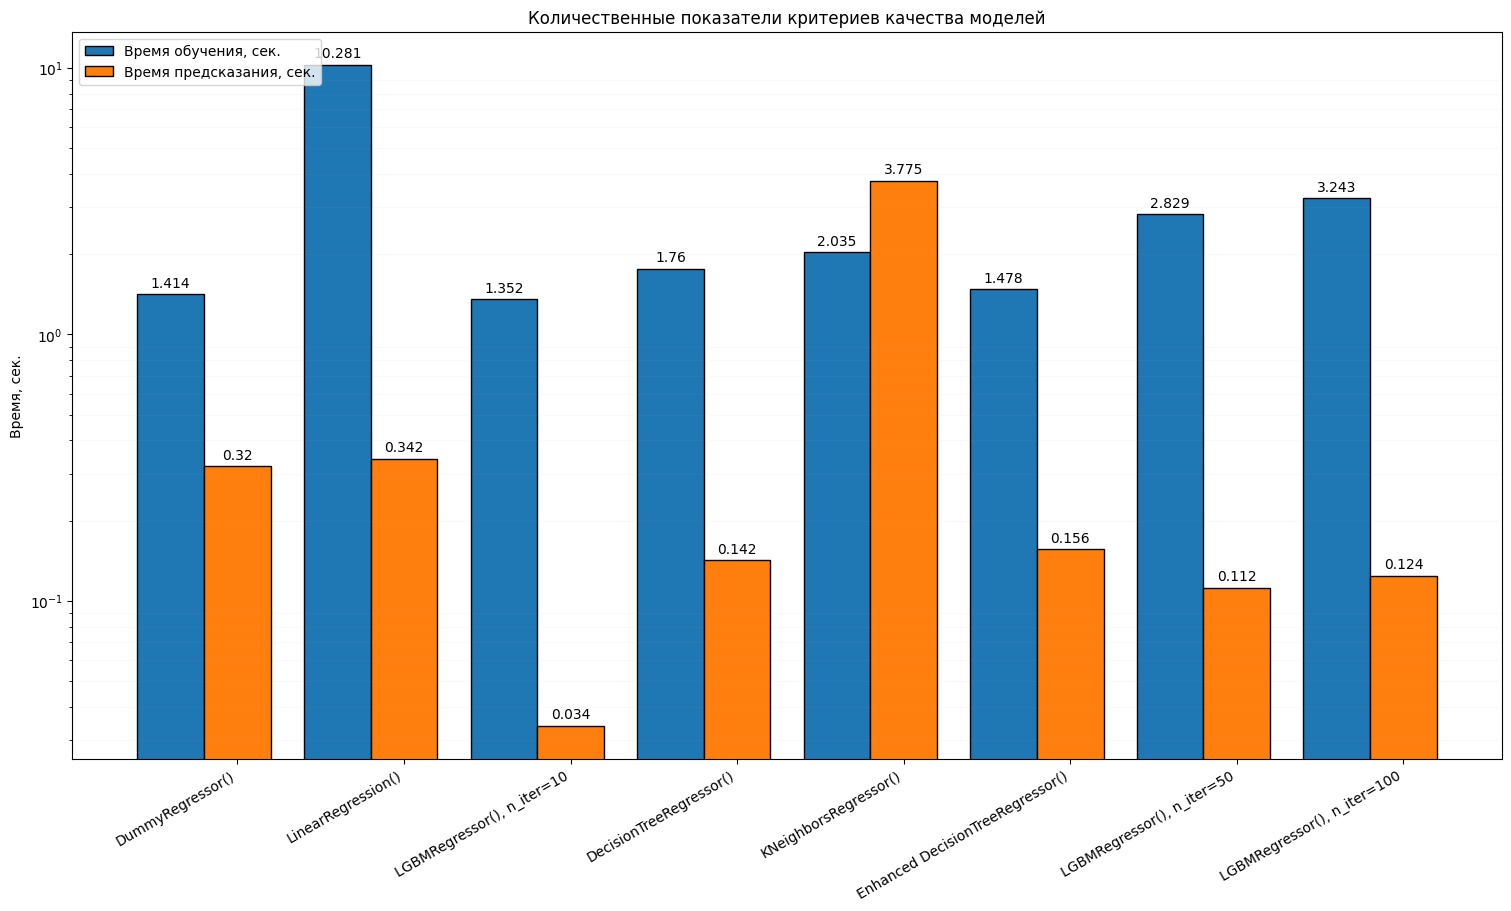

In [145]:
sorted_df = df_times.sort_values(by='Среднее значение RMSE при CV', ascending=False)

ticks = sorted_df['Наименование модели']
items = sorted_df.iloc[:,1:3]

x = np.arange(len(ticks))
width = 0.4
multiplier = 0

fig, ax = plt.subplots(figsize=(15, 9), layout='constrained')

for attribute, measurement in items.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute, log=True, edgecolor='black')
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel('Время, сек.')
ax.set_title('Количественные показатели критериев качества моделей')
ax.set_xticks(x + width, ticks, rotation=30, ha='right')
ax.grid(visible=True, which='minor', alpha=0.05)
ax.legend(loc='upper left')
plt.show()

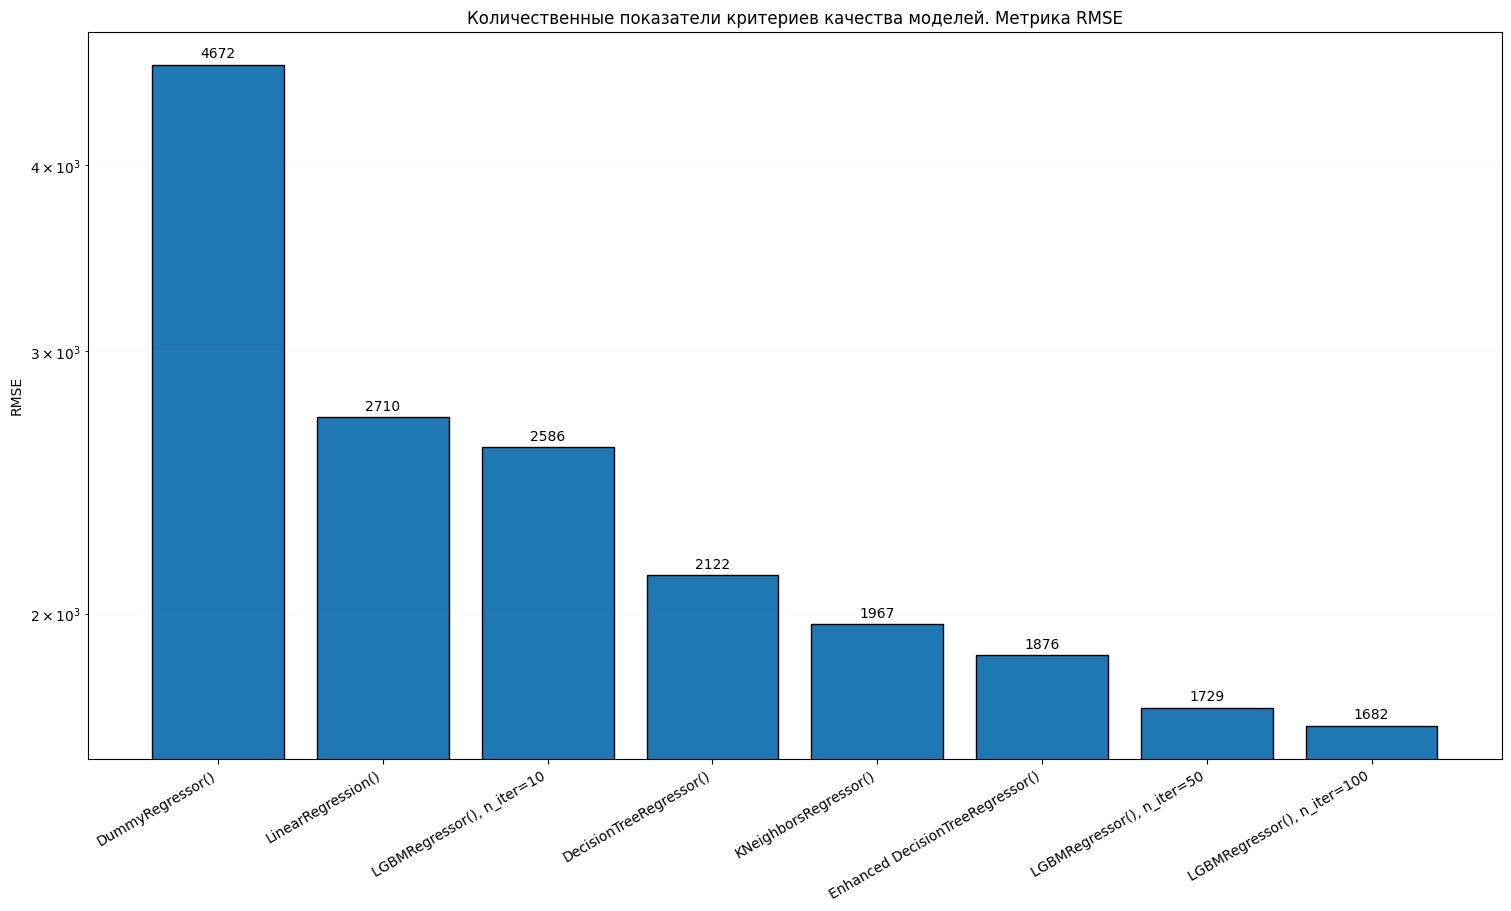

In [146]:
fig, ax = plt.subplots(figsize=(15, 9), layout='constrained')

rects = ax.bar(sorted_df['Наименование модели'], sorted_df['Среднее значение RMSE при CV'], log=True, edgecolor='black')

ax.set_ylabel('RMSE')
ax.set_title('Количественные показатели критериев качества моделей. Метрика RMSE')
ax.bar_label(rects, padding=3)
ax.set_xticks(np.arange(len(ticks)), sorted_df['Наименование модели'], rotation=30, ha='right')
ax.grid(visible=True, which='minor', alpha=0.05)
plt.show()

### Вывод по разделу "Анализ разработанных моделей МО" 

<a id='conclusion3' />

[Вернуться к началу](#begin)

В результате анализа времени обучения, времени предсказания и качества моделей сделаны следующие выводы:
1. Модель градиентного бустинга LightGBM с 10 итерациями  превзошла скорость обучения модели KNeighborsRegressor(), но её качество не удовлетворяем критериям заказчика.
2. У модели KNeighborsRegressor() самое высокое время предсказания при не самом лучшем качестве.
3. При этом, время обучения моделей Enhanced DecisionTreeRegressor() и LightGBM с 100 итерациями одного порядка с временем обучения KNeighborsRegressor(). Кроме того, их качество лучше KNeighborsRegressor().
4. Среди Enhanced DecisionTreeRegressor() и LightGBM с 100 итерациями предпочтение можно отдать более быстрой на формирование предсказаний (более чем в 2 раза) Enhanced DecisionTreeRegressor(), хотя её качество ниже на 8%.

В связи с изложенным, лучшей моделью для заказчика признана DecisionTreeRegressor() после подбора гиперпараметров:
1. Быстро обучается - около 0,619 секунд.
2. Быстро предсказывает - около 0,065 секунд.
3. Качественно предсказывает - RMSE 1876.

**Улучшение качества предсказания на 8% не обеспечивает победу значительно более медленной модели LightGBM.**

## Шаг 4. Оценка качества модели на тестовой выборке 

<a id='step4' />

[Вернуться к началу](#begin)

Выполним предсказания на выбранной модели на тестовой выборке и оценим её качество.

In [147]:
model = rs.best_estimator_
model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  []),
                                                 ('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['VehicleType', 'FuelType',
                                                   'Brand', 'Model', 'Repaired',
                                                   'Gearbox', 'Kilometer']),
                                                 ('num', StandardScaler(),
                                                  ['Power',
                                                   'RegistrationYear'])])),
                ('models',
                 DecisionTreeRegressor(max_depth=626, max_features=298,
                                       min_samples_leaf=7, min_samples_split=4,
                                       random_state=50))])

In [148]:
%%time

#Делаем предсказания и замеряем время предсказания
start_time = time.time()

y_pred_test = model.predict(X_test)

time_pred_test = time.time() - start_time

CPU times: total: 141 ms
Wall time: 149 ms


In [149]:
rmse_test = mean_squared_error(y_test, y_pred_test, squared=False)

In [150]:
print('Метрика RMSE лучшей модели на тестовой выборке:', rmse_test)

Метрика RMSE лучшей модели на тестовой выборке: 1829.2677564990945


In [151]:
print('Время предсказания лучшей модели на тестовой выборке:', time_pred_test)

Время предсказания лучшей модели на тестовой выборке: 0.14862394332885742


# Итоговый вывод  

<a id='conclusion' />

[Вернуться к началу](#begin)

В соответствии с планом работы были достигнуты следующие результаты.

**А. Изучение входных данных**

Для проведения исследования была получена выборка из 350_000 записей с данными о технических характеристиках, комплектации и ценах автомобилей, ранее представленных на рынке. Можно сделать _предварительный_ вывод, что предоставленных данных достаточно для достижения цели исследования. Были выявлены некоторые проблемы с входными данными, требующие предобработки: пропуски в данных, возможные дубликаты.

**Б. Предобработка данных**

В ходе предобработки данных:

1. Изучены и обработаны пропуски в данных. Пропуски данных в столбцах `VehicleType`, `Gearbox`, `Model`, `FuelType` были заполнены наиболее часто встречающимся значением среди аналогичных автомобилей одного бренда и модели (при этом пропуски в поле `Model` заполнены на основании сведений о брендах). Пропуски в столбце `Repaired` были заполнены значением 'yes' с учетом того, что в данных представлены автомобили с пробегом, а также того, что владельцы могли не указать факт ремонта автомобиля, чтобы скрыть его. 

2. Были обнаружены незначительное количество явных полных дубликатов в данных (4), а также большое количество неявных полных дубликатов. Таковые дубликаты были выявлены после анализа качества представленных заказчиком данных с точки зрения влияния признаков на цену автомобиля.  После удаление неинформативных признаков обнаруженные полные дубликаты были удалены. Кроме того, в данных найдены неявные дубликаты в поле `FuelType`, где имелись различные наименования одного и того же топлива ('gasoline' и 'petrol' для бензина), используемые в разных странах. Дубликаты были исключены.

    В дата-сете были представлены признаки (поля), которые не могут оказывать влияния на целевой признак (цену). Кроме того, из дата-сете не ясно, что отражает поле `RegestrationYear` - дата регистрации текущего владельца или дата выпуска автомобиля. У заказчика рекомендуется уточнить.

**В. Результаты исследовательского анализа**

В результате проведения исследовательского анализа были выявлены следующие факторы, влияющие на достижение цели работы.

1. Определены подходы к работе с категориальными признаками в части их кодирования для обучения моделей МО.  крмое того, выявлено, что признак `Kilometer` носит категориальный характер. 

2. В данных были обнаружены возможные выбросы (статистическим методом), однако не похожие на аномалии. В связи с этим, выбросы не удалялись. При этом, найдены и удалены ошибки в данных, связанные с наличием нулевых значений, минимальных единичных значений.

3. Произведена оценка распределений характеристик скважин и корелляционный анализ.

    Ключевые характеристики количественных признаков:
    - `RegistrationYear` - медиана 2003 год, 50% автомобилей в диапазоне 1999-2007 годы, минимум - 1923 год (раритеты не удалялись), максимум - 2016. Распределение признака визуально представляет собой распределение Пуассона.
    - `Power` - медиана 115.0 л.с., 50% автомобилей в диапазоне 80.00 л.с. - 150.00 л.с., минимум - 1 л.с., максимум - 600 л.с. Распределение признака визуально представляет собой распределение Пуассона.
    
    Очень сильной зависимости между входными признаками и целевым не выявлено (на целевой признак многие признаки влияют в некоторой степени линейно (значения коэффициентов от 0,3 до 0,6)). При этом, заметна очень сильная зависимость двух входных признаков (мультиколлинеарность): `VehicleType` и `Model`. Большая линейная зависимость с целевым признаком выявляется у входного признака `Model`. При разработке модлей МО учтем эту мультиколлинеарность и, при необходимости, удалим признак `VehicleType`, для линейных моделей. 
    
4. Ключевые характеристики целевого признака:
    - `Price` - медиана 3400.00, 50% автомобилей в диапазоне 1450.00 - 7290.00, минимум - 101, максимум - 20000.00. Распределение признака визуально представляет собой распределение Пуассона.    

**Г. Подготовка данных**

Для дальнейшего обучения моделей МО выполнены следующие работы:
- разработаны средства автоматизации процесса обучения моделей (pipeline) с учетом результатов предобработки данных;
- подготовлены выборки для обучения моделей соотношении 75% тренировочной выборки к 25% тестовой выборки.

**Д. Разработка моделей машинного обучения**

В результате проведенной работы по обучению моделей достигнуты следующие результаты:
1. В результате анализа целей и задач работы определены условия разработки моделей МО и сформирован план основного этапа моделирования. Принято решение пострить 5 моделей МО (Dummy, LinearRegression(), KNeighborsRegressor(), DecisionTreeRegressor() и LightGBM). 
2. Были обучены пять моделей и получены количественные показатели ключевых критериев для дальнейшего анализа.
3. Лучшая по метрике RMSE из обученных моделей показала низкий уровень критерия "скорость предсказания".
4. Для вторуй по качеству модели с приемлемым уровнем критериев скорости были подобраны гиперпараметры, которые позволили превзойти по качеству лучшую модель.
5. Кроме того, в ходе работы был обучен ансамбль моделей по алгоритму градиентного бустига и достигнуты значительные улучшения по всем критериям.
6. Получены сводные данные количественных показателей критериев всех моделей для дальнейшего анализа.

**Е. Анализ разработанных моделей МО**

В результате анализа времени обучения, времени предсказания и качества моделей сделаны следующие выводы:
1. Модель градиентного бустинга LightGBM с 10 итерациями  превзошла скорость обучения модели KNeighborsRegressor(), но её качество не удовлетворяем критериям заказчика.
2. У модели KNeighborsRegressor() самое высокое время предсказания при не самом лучшем качестве.
3. При этом, время обучения моделей Enhanced DecisionTreeRegressor() и LightGBM с 100 итерациями одного порядка с временем обучения KNeighborsRegressor(). Кроме того, их качество лучше KNeighborsRegressor().
4. Среди Enhanced DecisionTreeRegressor() и LightGBM с 100 итерациями предпочтение можно отдать более быстрой на формирование предсказаний (более чем в 2 раза) Enhanced DecisionTreeRegressor(), хотя её качество ниже на 8%.

    В связи с изложенным, лучшей моделью для заказчика признана DecisionTreeRegressor() после подбора гиперпараметров

**Ж. Оценка качества модели на тестовой выборке**

В результате проведенной работы лучшая модель для заказчика - DecisionTreeRegressor() после подбора гиперпараметров, которая:
1. Быстро обучилась на тренировочной выборке - около 0,619 секунд.
2. Быстро сформировала предсказания на тестовой выборке - около 0,115 секунд.
3. Сформировала качественные предсказания - RMSE 1829.

**З. Достижение цели работы**

Построена модель МО, которая предсказывает рыночную стоимость автомобиля на основе его характеристик, в пределах определенных требований к ее качеству и скорости.
Цель достигнута.

**И. Рекомендации бизнесу (дальнейшая работа)**
В результате работы выявлено, что в дата-сете имеются неиформативные признаки, а также фактически отсутствует важнейший признак - год выпуска автомобиля. Необходимо уточнить цели и целесообразность включения в дата-сет неинформативных признаков, а также уточнить сведения о признаке "год регистрации автомобиля", его значение.

In [152]:
notebook_time = time.time() - notebook_time_start
print(
    'Общее время выполнения: ',
    time.strftime("%H часов %M минут %S секунд", time.gmtime(notebook_time))
)

Общее время выполнения:  00 часов 04 минут 10 секунд


[Вернуться к началу](#begin)